# Plano atual do projeto:

1ª semana) Análise exploratória: olhar dados estruturados e observar tendências e sua lógica. Ex.: localização, nº candidatos, tipo de local de trabalho, habilidades requeridas, nível da vaga, setor da companhia.

2ª semana) Uso de NLP (BerTopic): modelo de tópicos usado com os dados do campo description
- https://maartengr.github.io/BERTopic/index.html

3ª semana) Análise cruzada entre tópicos mapeados com NLP e a análise exploratória / Uso de Langchain para categorizar e possivelmente corrigir nomes de posições inadequadas conforme a análise
- https://python.langchain.com/en/latest/

# Libraries and data imports

In [69]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

In [70]:
# Obtaining the data from all the archives extracted from Linkedin
df_jobs = pd.DataFrame()
for job in os.listdir('data'):
    if job[-4:] == '.csv':
        new_df = pd.read_csv(f'data/{job}', sep=';')
        df_jobs = pd.concat([df_jobs, new_df], axis=0)

# Initial EDA

In [71]:
print(df_jobs.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4486 entries, 0 to 937
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   position                4486 non-null   object 
 1   company                 4486 non-null   object 
 2   location                4486 non-null   object 
 3   posted_date             4482 non-null   object 
 4   no_applicants           3016 non-null   object 
 5   date_collected          4486 non-null   object 
 6   type_workplace          3877 non-null   object 
 7   required_skills         4269 non-null   object 
 8   competitive_advantages  0 non-null      float64
 9   level                   3766 non-null   object 
 10  worktype                4486 non-null   object 
 11  description             4486 non-null   object 
 12  link_application        4486 non-null   object 
 13  link_linkedin           4486 non-null   object 
 14  company_name            4482 non-null   o

This dataset has 4486 entries, most of which are fully filled. There is an entire blank column ('competitive advantages') and the remaining columns are all of the Dtype 'object', requiring conversion. There are a few NA values in the 'posted_date' and 'company_name' columns, which can be removed for better data integrity. We should analyse the remaining ones to decide what to do about the null values.

In [72]:
df_jobs.describe()

competitive_advantages
count                     0.0
mean                      NaN
std                       NaN
min                       NaN
25%                       NaN
50%                       NaN
75%                       NaN
max                       NaN

Since the .describe() method returns only the numerical columns when they are available and the only numerical column is entirely empty, let us refine our search with the argument 'exclude=np.number'

In [73]:
df_jobs.describe(exclude=np.number).T

count unique  \
position          4486   1850   
company           4486   1099   
location          4486    240   
posted_date       4482   4425   
no_applicants     3016    199   
date_collected    4486   4429   
type_workplace    3877      3   
required_skills   4269   2057   
level             3766      8   
worktype          4486     16   
description       4486   2161   
link_application  4486   2869   
link_linkedin     4486   4420   
company_name      4482   1079   
company_size      4486     53   
company_sector    4303    133   

                                                                                                                                                                                                                                                                                                                          top  \
position                                                                                                                                                                                                                                                                                                  Sports Statistician   
company                                                                                                                                                                                                                      {'name': 'Turing', 'size': '1.001-5.000 funcionários', 'sector': 'Serviços e consultoria de TI'}   
location                                                                                                                                                                                                                                                                                         São Paulo, São Paulo, Brasil   
posted_date                                                                                                                                                                                                                                                                                        2023-05-29 18:14:56.584167   
no_applicants                                                                                                                                                                                                                                                                                                 15 candidaturas   
date_collected                                                                                                                                                                                                                                                                                     2023-06-05 18:14:56.597077   
type_workplace                                                                                                                                                                                                                                                                                                     Presencial   
required_skills                                                                                                                                                                                       ['Esportes', 'Futebol americano', 'Internet Access', 'Setor de esportes', 'Skype', 'Treinamento', 'Táticas', 'YouTube']   
level                                                                                                                                                                                                                                                                                                            Pleno-sênior   
worktype                                                                                                                                                                                                                                             

Most of the columns is very diverse, which difficults initial categorization. There are 1850 names for positions, though the dataset is the result of a data extraction of the results of the query 'Data Analyst'. It shouldn't have so many different job positions, only a few. There are some other considerations to be done about the name of the position - namely, that it does not define a lot, since data analysts are pretty much a loosely defined occupation, mixing with data engineering, data scientist, among others.

'location' brings city, state and country, which can be better analysed in different columns. We will make this transformation futurely. We will also transform the column 'no_applicants', so it can be a numerical column. 'date_collected' and 'posted_date' will be converted to datetime (so far, there are only 'object' dtype columns), and the latter will have the hour, minute, and so on ommited. The reason for that is that the data extractor is not that precise, it is just an estimative, but having that much info gives an illusion of precision.

We can already notice that some values are impressively present in the dataset. 1275 records are from 'São Paulo, São Paulo, Brasil'; 1638 records of the type of the workplace are 'Presencial'; 1961 records of the level of the job position is 'Pleno-sênior'; and 4160 - almost all of the dataset - is 'Tempo Integral' worktype. Company_size and company_sector also have this disbalance.

Another interesting thing we can already infer from the dataset is the presence of repeated descriptions. This is worth mentioning because it is a text extracted integrally from Linkedin, which means it is position-specific. The 48 repeated positions, which appear to be related with sports, imply that there are positions with the exact same description. Why is that? Probably, it is the same position opened for different locations, but there could be another explanation.

'link_application' will be transformed so we can group the jobs which application is made in the same platform.
'link_linkedin' is not very relevant to us.

'company_size' requires transformation for better usage, but it might not be very relevant for the analysis we are interested.



In [74]:
df_jobs.head()

position  \
0                                        Analista de Gestão de Dados   
1                                             Marketing Data Analyst   
2                                              Football Statistician   
3  ­­­Analista Privacidade de Dados Sr – Prazo Determinado (6 meses)   
4                                               ANALISTA CADASTRO JR   

                                                                                                                   company  \
0                                                     {'name': 'Moove', 'size': '1.001-5.000 funcionários', 'sector': nan}   
1                       {'name': 'Valtech', 'size': '5.001-10.000 funcionários', 'sector': 'Serviços e consultoria de TI'}   
2                   {'name': 'Genius Sports', 'size': '1.001-5.000 funcionários', 'sector': 'Desenvolvimento de software'}   
3  {'name': 'CPFL Energia', 'size': '5.001-10.000 funcionários', 'sector': 'Serviços de eletricidade, gás, água e esgoto'}   
4                   {'name': 'AkzoNobel', 'size': '+ de 10.001 funcionários', 'sector': 'Fabricação de produtos químicos'}   

                       location                 posted_date     no_applicants  \
0  São Paulo, São Paulo, Brasil  2023-06-02 15:06:50.791991               NaN   
1            São Paulo e Região  2023-05-29 15:06:57.048773   77 candidaturas   
2        Crateús, Ceará, Brasil  2023-05-29 15:07:01.909347   47 candidaturas   
3   Campinas, São Paulo, Brasil  2023-05-29 15:07:15.555500   98 candidaturas   
4       Mauá, São Paulo, Brasil  2023-06-03 15:07:28.657900  101 candidaturas   

               date_collected type_workplace  \
0  2023-06-05 15:06:50.800990        Híbrido   
1  2023-06-05 15:06:57.059778            NaN   
2  2023-06-05 15:07:01.919349     Presencial   
3  2023-06-05 15:07:15.567136     Presencial   
4  2023-06-05 15:07:28.678311     Presencial   

                                                                                                                                                                                                                                   required_skills  \
0                                                                ['SQL', 'Alteryx', 'Azure Data Factory', 'Azure Data Lake', 'Data warehouse', 'ETL (Extração, transformação e carregamento)', 'Produtos SAP', 'SAP ERP', 'SSIS', 'Windows Azure']   
1  ['Analítica', 'Analítica de dados', 'Análise de marketing', 'Dashboards', 'Gerenciador de tags do Google', 'Habilidades analíticas', 'Hotjar', 'Indicadores-chave de desempenho', 'Otimização para mecanismos de busca (SEO)', 'Web Analytics']   
2                                                                                                                ['Esportes', 'Futebol americano', 'Inglês', 'Internet Access', 'Setor de esportes', 'Skype', 'Treinamento', 'Táticas', 'YouTube']   
3                             ['Análise de dados', 'Microsoft Excel', 'Avaliação de riscos', 'Conformidade regulatória', 'Contabilidade', 'Documentação', 'Habilidades analíticas', 'Inglês', 'Inteligência de negócios (BI)', 'Microsoft Office']   
4                                         ['Comunicação', 'Análise de negócios', 'Apresentações', 'Clientes internos', 'Comunicação interna', 'Documentação', 'Fontes tipográficas', 'Habilidades analíticas', 'Liderança de equipe', 'Relatório']   

   competitive_advantages         level        worktype  \
0                     NaN           NaN  Tempo integral   
1                     NaN  Pleno-sênior  Tempo integral   
2                     NaN    Assistente        Contrato   
3                     NaN           NaN  Tempo integral   
4                     NaN           NaN  Tempo integral   

                                                                                                                                                                                                                                                                      

In [75]:
df_jobs.tail()

position  \
933                     Developer ServiceNow ITOM/ITAM   
934                                     SRE Specialist   
935                  Estágio em Desenvolvimento Python   
936                             Consultor(a) FullStack   
937  Senior Data Engineer - DSP for Vibration Analysis   

                                                                                                                               company  \
933                                    {'name': 'Wipro', 'size': '+ de 10.001 funcionários', 'sector': 'Serviços e consultoria de TI'}   
934                                     {'name': 'Dock', 'size': '1.001-5.000 funcionários', 'sector': 'Serviços e consultoria de TI'}   
935  {'name': '4mti Soluções Ltda.', 'size': 'Veja como você se compara a 52 candidatos. Experimente o Premium grátis', 'sector': nan}   
936                                  {'name': 'Avanade', 'size': '+ de 10.001 funcionários', 'sector': 'Serviços e consultoria de TI'}   
937                                       {'name': 'TRACTIAN', 'size': '51-200 funcionários', 'sector': 'Desenvolvimento de software'}   

                                 location                 posted_date  \
933                     São Paulo, Brasil  2023-06-01 08:52:10.098846   
934                                Brasil  2023-05-30 08:52:13.172745   
935  Belo Horizonte, Minas Gerais, Brasil  2023-05-06 08:52:18.782909   
936          São Paulo, São Paulo, Brasil  2023-05-23 08:52:32.592300   
937                                Brasil  2023-05-16 08:52:41.297504   

       no_applicants              date_collected type_workplace  \
933  69 candidaturas  2023-06-06 08:52:10.117914         Remoto   
934  48 candidaturas  2023-06-06 08:52:13.182745         Remoto   
935  52 candidaturas  2023-06-06 08:52:18.800424        Híbrido   
936  54 candidaturas  2023-06-06 08:52:32.617668            NaN   
937  42 candidaturas  2023-06-06 08:52:41.326710         Remoto   

                                                                                                                                                                                                                    required_skills  \
933                                                        ['Articulação (TI)', 'CAD', 'Certificação ITIL', 'Gestão de eventos', 'ITIL', 'Instrução', 'Litígios', 'Projetos de migração', 'ServiceNow', 'Tecnologia da informação']   
934                                                                                                                                                                                  ['SRE (Engenharia de confiabilidade do site)']   
935                                                                                                                                                                                                                             NaN   
936  ['Comunicação', 'Estruturas de dados', 'Linguagens de programação', 'Análise de desempenho', 'Apresentações', 'Apresentações técnicas', 'Ciclo de vida de sistemas de informação', 'Graduate Entry', 'Negociação', 'Pesquisa']   
937                                                                                     ['NoSQL', 'Python', 'SQL', 'Amazon S3', 'Amazon Web Services', 'Análise de vibrações', 'C++', 'Ciência da computação', 'Inglês', 'MongoDB']   

     competitive_advantages         level        worktype  \
933                     NaN  Pleno-sênior  Tempo integral   
934                     NaN    Assistente  Tempo integral   
935                     NaN       Estágio  Tempo integral   
936                     NaN  Pleno-sênior  Tempo integral   
937                     NaN  Pleno-sênior  Tempo integral   

                                                                                                                                                                                                                                                                                

In [76]:
df_jobs.sample(5)

position  \
246                                Business Intelligence Lead   
402                     Quality Assurance Automation Engineer   
105                                     Desenvolvedor Tableau   
99   Senior Data Analyst (Bangkok Based, Relocation Provided)   
331                                         Stat Programmer 2   

                                                                                                                         company  \
246  {'name': 'Grupo Multi', 'size': '5.001-10.000 funcionários', 'sector': 'Fabricação de computadores e produtos eletrônicos'}   
402                                          {'name': 'ReMatter', 'size': '11-50 funcionários', 'sector': 'Serviços ambientais'}   
105                             {'name': 'Turing', 'size': '1.001-5.000 funcionários', 'sector': 'Serviços e consultoria de TI'}   
99                         {'name': 'Agoda', 'size': '5.001-10.000 funcionários', 'sector': 'Tecnologia, Informação e Internet'}   
331                           {'name': 'IQVIA', 'size': '+ de 10.001 funcionários', 'sector': 'Hospitais e atendimento à saúde'}   

                                 location                 posted_date  \
246                     São Paulo, Brasil  2023-05-30 18:59:32.066081   
402                                Brasil  2023-05-29 16:46:02.641693   
105                                Brasil  2023-06-01 20:09:03.759640   
99   Belo Horizonte, Minas Gerais, Brasil  2023-06-02 15:30:55.603245   
331          São Paulo, São Paulo, Brasil  2023-05-29 16:39:28.044281   

       no_applicants              date_collected type_workplace  \
246              NaN  2023-06-05 18:59:32.071067        Híbrido   
402              NaN  2023-06-05 16:46:02.645915         Remoto   
105   8 candidaturas  2023-06-05 20:09:03.773641         Remoto   
99               NaN  2023-06-05 15:30:55.610247            NaN   
331  11 candidaturas  2023-06-05 16:39:28.058298     Presencial   

                                                                                                                                                                                                               required_skills  \
246  ['Microsoft Excel', 'SQL', 'Administração de empresas', 'Análise de sistemas', 'Gestão de empresas', 'Habilidades analíticas', 'Inteligência de negócios (BI)', 'Microsoft Office', 'Relatório', 'Sistema de informação']   
402                                                                                                                                                                                                                        NaN   
105    ['Análise de dados', 'Tableau', 'Bancos de dados relacionais', 'Ciência da computação', 'Dashboards', 'Limpeza de dados', 'Preparação de dados', 'Resolução de problemas', 'Teoria das cores', 'Visualização de dados']   
99                        ['Capacidade de organização', 'Comunicação', 'Apresentações', 'Banco de investimento', 'Capital privado', 'Ciência de dados', 'Comunicação escrita', 'Dashboards', 'Marketing digital', 'Teste A/B']   
331                   ['Banco de dados', 'Desenvolvimento de software', 'Programação (computação)', 'SQL', 'Ciência da computação', 'Documentação', 'Estatística computacional', 'Padrões CDISC', 'Revisão de código', 'SDTM']   

     competitive_advantages         level        worktype  \
246                     NaN  Pleno-sênior        Contrato   
402                     NaN  Pleno-sênior  Tempo integral   
105                     NaN    Assistente  Tempo integral   
99                      NaN        Júnior  Tempo integral   
331                     NaN           NaN  Tempo integral   

                                                                                                                                                                                                                                                                                                     descriptio

The analysis of these records shows us that we can drop the column 'company', since it has the same data than in the company_name, company_size, and company_sector columns.

In [77]:
total_na = df_jobs.isna().sum()
perc_na = total_na / len(df_jobs)
pd.concat([total_na, perc_na], axis=1).rename({0: 'Total NA', 1: 'Perc. NA'}, axis=1).sort_values(by='Perc. NA', ascending=False)

Total NA  Perc. NA
competitive_advantages      4486  1.000000
no_applicants               1470  0.327686
level                        720  0.160499
type_workplace               609  0.135756
required_skills              217  0.048373
company_sector               183  0.040794
posted_date                    4  0.000892
company_name                   4  0.000892
date_collected                 0  0.000000
company                        0  0.000000
location                       0  0.000000
worktype                       0  0.000000
description                    0  0.000000
link_application               0  0.000000
link_linkedin                  0  0.000000
company_size                   0  0.000000
position                       0  0.000000

The competitive_advantages will be dropped, since it is completely null. Number of applicants, however, can have some relevance and it is one of the few numerical columns we have. 'posted_date' and 'company_name' have only 4 NA values and they will be deleted.

I'm not sure of what to do about the remaining NA columns. Should I just focus in the values I have and ignore the records that have null values? I can't really consider details about skills if they aren't there, so it is not useful. Probably, the 217 NA records occurred because of some error of the data extractor. Anyway, it is different to exclude 217 records to exclude 720, for example. Let's see more details about those NA values.

In [78]:
df_jobs.level.value_counts()

Pleno-sênior                       1961
Assistente                         1254
Júnior                              438
Estágio                              71
Diretor                              17
Executivo                            13
Tempo integral                       11
Fabricação de produtos químicos       1
Name: level, dtype: int64

There are mistakes in this column, but we cannot infer the value of the remaining columns. It would be best to drop it.

In [79]:
df_jobs.type_workplace.value_counts()

Presencial    1638
Híbrido       1227
Remoto        1012
Name: type_workplace, dtype: int64

The column has significant amounts in every possible record; we can't just fill the remaining ones, we should drop it.

In [80]:
df_jobs.required_skills.value_counts()

['Esportes', 'Futebol americano', 'Internet Access', 'Setor de esportes', 'Skype', 'Treinamento', 'Táticas', 'YouTube']                                                                                                                  50
['Capacidade de organização', 'Comunicação', 'Apresentações', 'Banco de investimento', 'Ciência de dados', 'Comunicação escrita', 'Comércio eletrônico', 'Marketing digital', 'Serviços de publicidade online', 'Teste A/B']             36
['Capacidade de organização', 'Comunicação', 'Apresentações', 'Banco de investimento', 'Capital privado', 'Comunicação escrita', 'Comércio eletrônico', 'Marketing digital', 'Serviços de publicidade online', 'Teste A/B']              31
['Análise de dados', 'Analítica', 'Analítica de dados', 'Atenção a detalhes', 'Ciência de dados', 'ETL (Extração, transformação e carregamento)', 'Looker (Software)', 'Mineração de dados', 'Visualização', 'Visualização de dados']    29
['Banco de dados', 'Redação', 'Android', 'Aprendizado de

As commented before, it is a very diverse column. It is best to drop the NA rows.

In [81]:
df_jobs.company_sector.value_counts()

Serviços e consultoria de TI               1271
Desenvolvimento de software                 437
Tecnologia, Informação e Internet           248
Serviços financeiros                        228
Tecnologia da informação e serviços         112
                                           ... 
Instalações de jogos de azar e cassinos       1
Contabilidade                                 1
Serviços para energia renovável               1
Serviços de relações com o governo            1
Serviços de engenharia                        1
Name: company_sector, Length: 133, dtype: int64

Probably would'nt impact a lot our analysis to consider that the NA values are of the sector 'Serviços e consultoria de TI'; but I will just delete them too.

# Treating the data

First, let's fix the fact that there are a lot of repeated indexes.

In [82]:
df_jobs = df_jobs.reset_index()
df_jobs = df_jobs.drop(['index'], axis=1)
df_jobs.tail(2)

position  \
4484                             Consultor(a) FullStack   
4485  Senior Data Engineer - DSP for Vibration Analysis   

                                                                                                company  \
4484  {'name': 'Avanade', 'size': '+ de 10.001 funcionários', 'sector': 'Serviços e consultoria de TI'}   
4485       {'name': 'TRACTIAN', 'size': '51-200 funcionários', 'sector': 'Desenvolvimento de software'}   

                          location                 posted_date  \
4484  São Paulo, São Paulo, Brasil  2023-05-23 08:52:32.592300   
4485                        Brasil  2023-05-16 08:52:41.297504   

        no_applicants              date_collected type_workplace  \
4484  54 candidaturas  2023-06-06 08:52:32.617668            NaN   
4485  42 candidaturas  2023-06-06 08:52:41.326710         Remoto   

                                                                                                                                                                                                                     required_skills  \
4484  ['Comunicação', 'Estruturas de dados', 'Linguagens de programação', 'Análise de desempenho', 'Apresentações', 'Apresentações técnicas', 'Ciclo de vida de sistemas de informação', 'Graduate Entry', 'Negociação', 'Pesquisa']   
4485                                                                                     ['NoSQL', 'Python', 'SQL', 'Amazon S3', 'Amazon Web Services', 'Análise de vibrações', 'C++', 'Ciência da computação', 'Inglês', 'MongoDB']   

      competitive_advantages         level        worktype  \
4484                     NaN  Pleno-sênior  Tempo integral   
4485                     NaN  Pleno-sênior  Tempo integral   

                                                                                                                                                                                                                                                                                                      description  \
4484  Sobre a vaga\nJob Description\n\nConsultor(a) FullStack\n\nTe introduzindo então à equipe...\n\nComo Consultor(a), você será responsável por desenhar, propor e desenvolver soluções baseadas nas necessidades dos clientes. Liderar e dar auxílio técnico a equipe de desenvolvimento, garantindo os ma...   
4485  Sobre a vaga\nWhat you'll do\n\nWe are looking for a highly motivated and skilled Data Engineer with expertise in Digital Signal Processing (DSP) for Vibration Analysis Sensors to join our team. The ideal candidate will be responsible for designing, developing, and maintaining data pipelines and...   

                                                                                link_application  \
4484  https://careers.avanade.com/jobsenus/JobDetail/Consultor-a-FullStack/63392?source=LinkedIn   
4485                                      https://tractian.com/carreiras/vagas/recwwW4gV0kSPGxge   

                                                                                                                                                                                link_linkedin  \
4484    https://www.linkedin.com/jobs/view/3588922575/?alternateChannel=search&refId=Jr0PwYdRo2Az2LRt5sYI6A%3D%3D&trackingId=drd%2BAocxDHTEG%2BP5LLg1Uw%3D%3D&trk=d_flagship3_search_srp_jobs   
4485  https://www.linkedin.com/jobs/view/3602652766/?alternateChannel=search&refId=Jr0PwYdRo2Az2LRt5sYI6A%3D%3D&trackingId=hvBi4m4DHn%2BSf%2BJTanZV%2BA%3D%3D&trk=d_flagship3_search_srp_jobs   

     company_name              company_size                company_sector  
4484      Avanade  + de 10.001 funcionários  Serviços e consultoria de TI  
4485     TRACTIAN       51-200 funcionários   Desenvolvimento de software

Now, let's drop the irrelevant columns...

In [83]:
# Dropping columns
to_drop_cols = ['competitive_advantages', 'company']
df_jobs = df_jobs.drop(to_drop_cols, axis=1)
df_jobs.head(2)

position                      location  \
0  Analista de Gestão de Dados  São Paulo, São Paulo, Brasil   
1       Marketing Data Analyst            São Paulo e Região   

                  posted_date    no_applicants              date_collected  \
0  2023-06-02 15:06:50.791991              NaN  2023-06-05 15:06:50.800990   
1  2023-05-29 15:06:57.048773  77 candidaturas  2023-06-05 15:06:57.059778   

  type_workplace  \
0        Híbrido   
1            NaN   

                                                                                                                                                                                                                                   required_skills  \
0                                                                ['SQL', 'Alteryx', 'Azure Data Factory', 'Azure Data Lake', 'Data warehouse', 'ETL (Extração, transformação e carregamento)', 'Produtos SAP', 'SAP ERP', 'SSIS', 'Windows Azure']   
1  ['Analítica', 'Analítica de dados', 'Análise de marketing', 'Dashboards', 'Gerenciador de tags do Google', 'Habilidades analíticas', 'Hotjar', 'Indicadores-chave de desempenho', 'Otimização para mecanismos de busca (SEO)', 'Web Analytics']   

          level        worktype  \
0           NaN  Tempo integral   
1  Pleno-sênior  Tempo integral   

                                                                                                                                                                                                                                                                                                   description  \
0  Sobre a vaga\nPosição: Analista de Gestão de Dados\nÁrea: TI\nLocal de Trabalho: São Paulo (Híbrido)\n\nDesafio:\nA Moove está buscando um Analista de Gestão de Dados para a área de Tecnologia que participará ativamente nas demandas e projetos se comunicando com todas as áreas de negócios. Utili...   
1  Sobre a vaga\nA Valtech é uma Agência Digital global que possui escritórios em 22 países. Nós projetamos e construímos experiências únicas, executamos esforços de melhoria contínua e vivemos, alimentamos e impulsionamos a transformação dos negócios em todo o mundo digital. Apoiamos nossos client...   

                                                                                                                                                                    link_application  \
0  https://www.linkedin.com/jobs/view/3624224677/?alternateChannel=search&refId=tCWVCdLmkJlTrZ5vCMuj9w%3D%3D&trackingId=riP9DcjjA6I7Vswe6da0Iw%3D%3D&trk=d_flagship3_search_srp_jobs   
1                                                                                                             https://careers.brazil.valtech.com/jobs/2727912-marketing-data-analyst   

                                                                                                                                                                       link_linkedin  \
0  https://www.linkedin.com/jobs/view/3624224677/?alternateChannel=search&refId=tCWVCdLmkJlTrZ5vCMuj9w%3D%3D&trackingId=riP9DcjjA6I7Vswe6da0Iw%3D%3D&trk=d_flagship3_search_srp_jobs   
1  https://www.linkedin.com/jobs/view/3613520213/?alternateChannel=search&refId=tCWVCdLmkJlTrZ5vCMuj9w%3D%3D&trackingId=fdTnCgftVOU3WAZKu2gUWw%3D%3D&trk=d_flagship3_search_srp_jobs   

  company_name               company_size                company_sector  
0        Moove   1.001-5.000 funcionários                           NaN  
1      Valtech  5.001-10.000 funcionários  Serviços e consultoria de TI

And the problematic rows with NA values

In [84]:
total_na = df_jobs.isna().sum()
perc_na = total_na / len(df_jobs)
pd.concat([total_na, perc_na], axis=1).rename({0: 'Total NA', 1: 'Perc. NA'}, axis=1).sort_values(by='Perc. NA', ascending=False)

Total NA  Perc. NA
no_applicants         1470  0.327686
level                  720  0.160499
type_workplace         609  0.135756
required_skills        217  0.048373
company_sector         183  0.040794
posted_date              4  0.000892
company_name             4  0.000892
position                 0  0.000000
location                 0  0.000000
date_collected           0  0.000000
worktype                 0  0.000000
description              0  0.000000
link_application         0  0.000000
link_linkedin            0  0.000000
company_size             0  0.000000

In [85]:
# Dropping rows
df_jobs = df_jobs.dropna(axis=0, subset=['posted_date', 'company_name', 'level', 'type_workplace', 'required_skills', 'company_sector'])
total_na = df_jobs.isna().sum()
perc_na = total_na / len(df_jobs)
pd.concat([total_na, perc_na], axis=1).rename({0: 'Total NA', 1: 'Perc. NA'}, axis=1).sort_values(by='Perc. NA', ascending=False)

Total NA  Perc. NA
no_applicants         1084  0.355293
position                 0  0.000000
location                 0  0.000000
posted_date              0  0.000000
date_collected           0  0.000000
type_workplace           0  0.000000
required_skills          0  0.000000
level                    0  0.000000
worktype                 0  0.000000
description              0  0.000000
link_application         0  0.000000
link_linkedin            0  0.000000
company_name             0  0.000000
company_size             0  0.000000
company_sector           0  0.000000

We have now 1400 less records than before

In [86]:
df_jobs.shape

(3051, 15)

Let's remove the duplicates records

In [87]:
# Evaluating duplicates
cols_duplication = ['company_name', 'position', 'location']
mask_duplicates = df_jobs[cols_duplication].duplicated()
print('Nº duplicates:', df_jobs[mask_duplicates].shape)
df_jobs = df_jobs[~mask_duplicates]
print('Nº not duplicates:', df_jobs.shape)

Nº duplicates: (1493, 15)
Nº not duplicates: (1558, 15)


Now, we can proceed to data transformation

In [88]:
# Location:
df_jobs.location.value_counts()

São Paulo, São Paulo, Brasil              385
Brasil                                    244
São Paulo, Brasil                         167
Rio de Janeiro, Rio de Janeiro, Brasil     62
São Paulo e Região                         51
                                         ... 
Cabedelo, Paraíba, Brasil                   1
Goiás, Goiás, Brasil                        1
Juiz de Fora, Minas Gerais, Brasil          1
Atibaia, São Paulo, Brasil                  1
Rio Claro, São Paulo, Brasil                1
Name: location, Length: 195, dtype: int64

In [89]:
mask_has_comma = df_jobs['location'].str.contains(', ')
df_jobs[mask_has_comma]['location'].unique()

array(['Crateús, Ceará, Brasil', 'Goiânia, Goiás, Brasil',
       'Luís Eduardo Magalhães, Bahia, Brasil',
       'São Paulo, São Paulo, Brasil', 'Paulínia, São Paulo, Brasil',
       'São Paulo, Brasil', 'Nova Mutum, Mato Grosso, Brasil',
       'Belo Horizonte, Minas Gerais, Brasil',
       'Rio de Janeiro, Rio de Janeiro, Brasil',
       'Rio Verde, Goiás, Brasil', 'Sapezal, Mato Grosso, Brasil',
       'Embu das Artes, São Paulo, Brasil', 'Cotia, São Paulo, Brasil',
       'Indaiatuba, São Paulo, Brasil', 'Valinhos, São Paulo, Brasil',
       'São José do Rio Preto, São Paulo, Brasil',
       'Porto Alegre, Rio Grande do Sul, Brasil', 'Iporá, Goiás, Brasil',
       'Curitiba, Paraná, Brasil',
       'São José dos Campos, São Paulo, Brasil',
       'Araçatuba, São Paulo, Brasil', 'Fortaleza, Ceará, Brasil',
       "Santa Bárbara d'Oeste, São Paulo, Brasil",
       'Betim, Minas Gerais, Brasil', 'Sumaré, São Paulo, Brasil',
       'Juazeiro do Norte, Ceará, Brasil',
       'Nova Vené

In [90]:
df_jobs['city'] = df_jobs[mask_has_comma].location.map(lambda x: x.split(', ')[0])
df_jobs.loc[~mask_has_comma, 'city'] = df_jobs[~mask_has_comma].location.map(lambda x: x if 'Região' in x else np.nan)
df_jobs['state'] = df_jobs[mask_has_comma].location.map(lambda x: x.split(', ')[1] if x.split(', ')[1] != 'Brasil' else np.nan)
df_jobs['country'] = df_jobs[mask_has_comma].location.map(lambda x: x.split(', ')[-1])
df_jobs.loc[df_jobs['location'] == 'Brasil', 'country'] = 'Brasil'

In [91]:
mask_is_regiao = df_jobs['location'].str.contains('Região')
mask_is_only_brasil = (df_jobs['location'] == 'Brasil')
df_jobs.loc[~mask_has_comma & ~mask_is_regiao & ~mask_is_only_brasil, 'country'] = df_jobs.loc[~mask_has_comma & ~mask_is_regiao & ~mask_is_only_brasil]['location']

In [92]:
df_jobs.loc[~mask_has_comma & ~mask_is_regiao & ~mask_is_only_brasil]

position        location  \
79                 Junior Developer  América Latina   
237                    Data Analyst  América Latina   
2778                 MLOps Engineer  América Latina   
3872      Data Analytics Specialist  América Latina   
4295  Senior Data Scientist - LATAM  América Latina   

                     posted_date    no_applicants              date_collected  \
79    2023-05-15 15:29:08.958859              NaN  2023-06-05 15:29:08.963861   
237   2023-05-22 15:44:17.066744              NaN  2023-06-05 15:44:17.073041   
2778  2023-06-05 17:50:41.434259  10 candidaturas  2023-06-05 20:50:41.445178   
3872  2023-06-03 07:53:06.451917              NaN  2023-06-06 07:53:06.456918   
4295  2023-05-30 08:34:11.795529              NaN  2023-06-06 08:34:11.805506   

     type_workplace  \
79           Remoto   
237          Remoto   
2778         Remoto   
3872         Remoto   
4295         Remoto   

                                                                                                                                                                                                                                           required_skills  \
79                                                                                                                                   ['Comunicação', 'Bancos de dados para CRM', 'ClickUp', 'HubSpot', 'Inglês', 'Salesforce.com', 'Trabalho em projetos']   
237                                                   ['Análise de dados', 'Linguagens de programação', 'Analítica', 'Análise de Big Data', 'Estatística', 'Habilidades analíticas', 'Inglês', 'Methane', 'Sensoriamento remoto', 'Visualização de dados']   
2778                                      ['Comunicação', 'JavaScript', 'Ciência da computação', 'Ciência de dados', 'Desenvolvimento de front-end', 'Desenvolvimento web', 'Flask', 'Habilidades analíticas', 'IA responsável', 'Resolução de problemas']   
3872                                                    ['Python', 'SQL', 'Tableau', 'Assistência ao produto', 'Data warehouse', 'Desenvolvimento full stack', 'Habilidades analíticas', 'Microsoft Power BI', 'Modelagem de dados', 'Árvores de decisão']   
4295  ['Aprendizado de máquina', 'Aprendizagem', 'Benefícios de funcionários', 'Campanhas publicitárias', 'Ciência de dados', 'Compensation', 'Inteligência artificial', 'LATAM', 'Processamento de linguagem natural (PLN)', 'Reconhecimento de padrões']   

             level        worktype  \
79      Assistente  Tempo integral   
237         Júnior  Tempo integral   
2778    Assistente  Tempo integral   
3872  Pleno-sênior  Tempo integral   
4295  Pleno-sênior  Tempo integral   

                                                                                                                                                                                                                                                                                                      description  \
79    Sobre a vaga\nResponsibilities\n·Monitor systems to ensure automated services are working.\n·Implement system improvements (including managing third party changes) including minor changes and project work.\n·Manage and customize internal CRM system.\n\nBasic Qualifications\n·Excellent communicat...   
237   Sobre a vaga\nPosition: Data Analysis Associate (Methane Program)\n\nReporting to: Methane Program Director\n\nRemuneration: Remuneration will be competitive, based on successful applicant’s experience\n\nLocation: This is a work from anywhere job (remote)\n\nStart date: As soon as possible\n\nD...   
2778  Sobre a vaga\nBecome an Outcoder as a MLOps Engineer:\n\nPosition Summary\n\nWe are seeking a skilled and experienced Software Engineer (contractor) with a focus on Large Language Models (LLMs) to perform development and testing of extractive and generative AI capabilities to create impact for o...   
3872  Sobre a vaga\nAbout The Role\n\nWe are on a journey from 18 > 100 million 

In [93]:
df_jobs.head()

position  \
2                                   Football Statistician   
6                                       Analista de dados   
8   Analista de Logística JR – Luís Eduardo Magalhães /BA   
9                                    ANALISTA DE BI PLENO   
10                       Analista de Controladoria Júnior   

                                 location                 posted_date  \
2                  Crateús, Ceará, Brasil  2023-05-29 15:07:01.909347   
6                  Goiânia, Goiás, Brasil  2023-05-22 15:08:22.703756   
8   Luís Eduardo Magalhães, Bahia, Brasil  2023-05-22 15:08:59.545413   
9            São Paulo, São Paulo, Brasil  2023-06-01 15:09:20.636449   
10           São Paulo, São Paulo, Brasil  2023-06-05 14:09:23.204315   

       no_applicants              date_collected type_workplace  \
2    47 candidaturas  2023-06-05 15:07:01.919349     Presencial   
6   183 candidaturas  2023-06-05 15:08:22.716265        Híbrido   
8                NaN  2023-06-05 15:08:59.549807     Presencial   
9                NaN  2023-06-05 15:09:20.652336        Híbrido   
10   55 candidaturas  2023-06-05 15:09:23.216402     Presencial   

                                                                                                                                                                                           required_skills  \
2                                                                        ['Esportes', 'Futebol americano', 'Inglês', 'Internet Access', 'Setor de esportes', 'Skype', 'Treinamento', 'Táticas', 'YouTube']   
6   ['Análise de dados', 'Estruturas de dados', 'Python', 'Bancos de dados relacionais', 'Estatística', 'Otimização', 'Probabilidade', 'Redes neurais', 'Resolução de problemas', 'Sistema de informação']   
8                                                                                                                                                     ['Microsoft Excel', 'Inteligência de negócios (BI)']   
9          ['Linguagens de programação', 'Microsoft Excel', 'Programação (computação)', 'SQL', 'Consultoria', 'Cursos', 'Inteligência de negócios (BI)', 'Programação SAS', 'Promoção da inclusão', 'SAS']   
10         ['Análise de dados', 'Comunicação', 'Focal Point', 'Habilidades analíticas', 'Implementação de processo', 'Pipedrive', 'Raciocínio analítico', 'Relatório', 'Resolução de problemas', 'Trello']   

           level        worktype  \
2     Assistente        Contrato   
6   Pleno-sênior  Tempo integral   
8     Assistente  Tempo integral   
9   Pleno-sênior  Tempo integral   
10    Assistente  Tempo integral   

                                                                                                                                                                                                                                                                                                    description  \
2   Sobre a vaga\nLove sports?\n\nWe're looking for someone like you!\n\nJob type - Contract based (Not part-time or full-time)\n\nGet to know us - https://geniussports.com/statisticians-network/\n\nThis is an opportunity for exciting and fast-paced work as a Football Statistician.\n\nIf you enjoy s...   
6   Sobre a vaga\n01 VAGA ANALISTA DE DADOS.\n\nRequisitos:\nEnsino Superior Completo ciências de dados, sistema da informação, ou áreas a fins\nVivência em ciência de dados, incluindo advanced analytics, machine learning e otimização;\nConhecimentos sobre o funcionamento dos principais modelos de M...   
8   Sobre a vaga\nPROPÓSITO E IMPACTO DO TRABALHO\n\nO Analista de Logística JR ajudará a planejar, acompanhar a execução de fluxos logísticos e avaliar o desempenho das execuções de grãos e insumos nos principais modais, Rodoviário, ferroviário e hidroviário. Buscamos um profissional que nos ajude ...   
9   Sobre a vaga\nQUEM SOMOS?\n\nUma das maiores seguradoras do mundo, temos como pilar a sustentabilidade e o cuidado com as pessoas. Possuímos um amplo port

In [94]:
df_jobs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1558 entries, 2 to 4482
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   position          1558 non-null   object
 1   location          1558 non-null   object
 2   posted_date       1558 non-null   object
 3   no_applicants     988 non-null    object
 4   date_collected    1558 non-null   object
 5   type_workplace    1558 non-null   object
 6   required_skills   1558 non-null   object
 7   level             1558 non-null   object
 8   worktype          1558 non-null   object
 9   description       1558 non-null   object
 10  link_application  1558 non-null   object
 11  link_linkedin     1558 non-null   object
 12  company_name      1558 non-null   object
 13  company_size      1558 non-null   object
 14  company_sector    1558 non-null   object
 15  city              1309 non-null   object
 16  state             1004 non-null   object
 17  country       

In [95]:
# Dtype conversion
df_jobs['posted_date'] = pd.to_datetime(df_jobs['posted_date'].str[:10])

In [96]:
df_jobs['date_collected'] = pd.to_datetime(df_jobs['date_collected'])

In [97]:
df_jobs.no_applicants.value_counts()

10 candidaturas     18
3 candidaturas      15
14 candidaturas     15
18 candidaturas     14
15 candidaturas     14
                    ..
198 candidaturas     1
193 candidaturas     1
169 candidaturas     1
94 candidaturas      1
194 candidaturas     1
Name: no_applicants, Length: 189, dtype: int64

In [98]:
df_jobs['no_applicants'] = df_jobs[df_jobs['no_applicants'].notna()].no_applicants.map(lambda x: x.split()[0]).astype('int')
df_jobs.loc[:, 'no_applicants'].fillna(0, axis=0, inplace=True)

In [99]:
df_jobs.no_applicants.value_counts()

0.0      570
10.0      18
14.0      15
3.0       15
2.0       14
        ... 
198.0      1
193.0      1
169.0      1
94.0       1
194.0      1
Name: no_applicants, Length: 190, dtype: int64

In [100]:
df_jobs.describe()

no_applicants
count    1558.000000
mean       44.244544
std        54.073702
min         0.000000
25%         0.000000
50%        20.000000
75%        76.750000
max       199.000000

In [101]:
df_jobs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1558 entries, 2 to 4482
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   position          1558 non-null   object        
 1   location          1558 non-null   object        
 2   posted_date       1558 non-null   datetime64[ns]
 3   no_applicants     1558 non-null   float64       
 4   date_collected    1558 non-null   datetime64[ns]
 5   type_workplace    1558 non-null   object        
 6   required_skills   1558 non-null   object        
 7   level             1558 non-null   object        
 8   worktype          1558 non-null   object        
 9   description       1558 non-null   object        
 10  link_application  1558 non-null   object        
 11  link_linkedin     1558 non-null   object        
 12  company_name      1558 non-null   object        
 13  company_size      1558 non-null   object        
 14  company_sector    1558 n

In [1]:
df_jobs.worktype.value_counts()

NameError: name 'df_jobs' is not defined

In [103]:
mask_worktype_inadequate = (df_jobs['worktype'].str.contains('/month')) | (df_jobs['worktype'].str.contains('funcionários'))
df_jobs = df_jobs.drop(df_jobs[mask_worktype_inadequate].index, axis=0)

In [104]:
df_jobs.worktype.value_counts()

Tempo integral    1454
Contrato            65
Estágio             18
Meio período         9
Temporário           3
Name: worktype, dtype: int64

I should probably treat the 'position' data

In [105]:
df_exploded_skills = df_jobs['required_skills'].dropna().map(lambda x: eval(x)).explode().reset_index()

In [106]:
def process_url(url):
    url = url.split('//')[1].split('/')[0].replace('www.', '')
    if '.gupy.io' in url:
        return 'gupy.io'
    if '.infojobs.com.br' in url:
        return 'infojobs.com.br'
    return url

df_jobs['link_application_simplified'] = df_jobs.link_application.map(process_url)

In [107]:
df_jobs.position.value_counts()

Work From Home Python Developer                                          20
Sports Statistician                                                      16
Football Statistician                                                    12
Data Engineer                                                            12
Senior Data Analyst - Remote - Latin America                             11
                                                                         ..
Analista de Dados - Edtech                                                1
Analista DBA Sênior                                                       1
Business Hunter (Chinese Speaker)                                         1
Analista Sênior de Business Intelligence e Analytics - Mercado Envios     1
DELMIA Apriso Consultant                                                  1
Name: position, Length: 1256, dtype: int64

In [108]:
pd.options.display.max_colwidth = 300

In [109]:
def otimize_positions(position):
    position = position.lower()
    remove_expressions = ['work from home', 'remote', 'sênior', ' sr', 'senior', 'latin america', 'ii', 'brazil', ' in ', 'online', 'job', 'banco de talentos', 'work']
    for expression in remove_expressions:
        position = position.replace(expression, '')
    position = position.replace('(', '')
    position = position.replace(')', '')
    position = position.replace('-', '')
    return position.strip().title()

df_jobs.position.map(otimize_positions).value_counts()[30:40]

Full Stack Engineer                              3
Analista Fiscal                                  3
Pessoa Desenvolvedora E Consultora Vlocity       3
Aws Data Engineer                                3
Analista De Qualidade                            3
Solution Architectindustry Solutions Delivery    3
Customer Support Analyst                         3
Database Engineer                                3
Analista De Marketing                            3
Analista De Planejamento                         3
Name: position, dtype: int64

In [110]:
all_positions = ' '.join(df_jobs['position']).lower()
words_list = all_positions.split()
counted_words = Counter(words_list)
df_position_words = pd.DataFrame.from_dict(counted_words, orient='index', columns=['frequency'])
df_position_words.index.name = 'word'
df_position_words = df_position_words.reset_index().sort_values(by='frequency', ascending=False)

<Axes: xlabel='frequency', ylabel='word'>

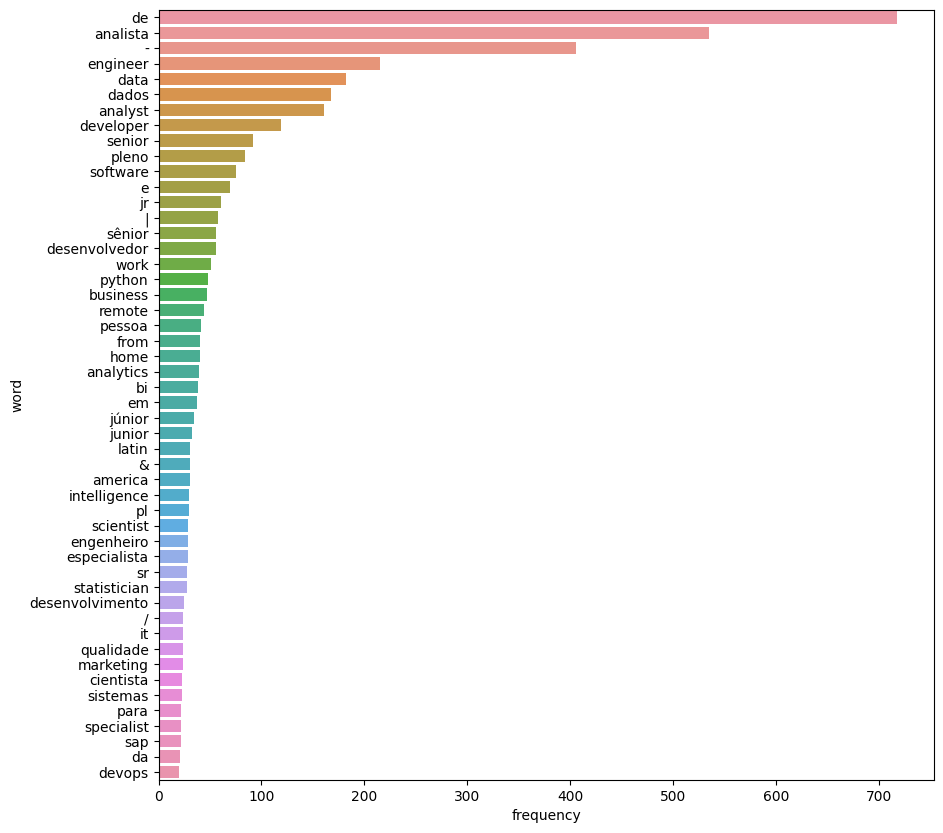

In [68]:
plt.subplots(figsize=(10,10))
sns.barplot(data=df_position_words.head(50), y='word', x='frequency')

# Exploring the data

In [111]:
def generate_count(dataframe, to_group_column, to_count_column):
    return dataframe.groupby(to_group_column)[to_count_column].count().reset_index().sort_values(ascending=False, by=to_count_column)

In [112]:
df_jobs.columns

Index(['position', 'location', 'posted_date', 'no_applicants',
       'date_collected', 'type_workplace', 'required_skills', 'level',
       'worktype', 'description', 'link_application', 'link_linkedin',
       'company_name', 'company_size', 'company_sector', 'city', 'state',
       'country', 'link_application_simplified'],
      dtype='object')

In [113]:
counted_columns = dict()
for col in ['posted_date', 'no_applicants',
        'type_workplace', 'level',
       'worktype',
       'company_name', 'company_size', 'company_sector', 'city', 'state',
       'country', 'link_application_simplified']:
    counted_columns[col] = generate_count(df_jobs, col, ['position'])

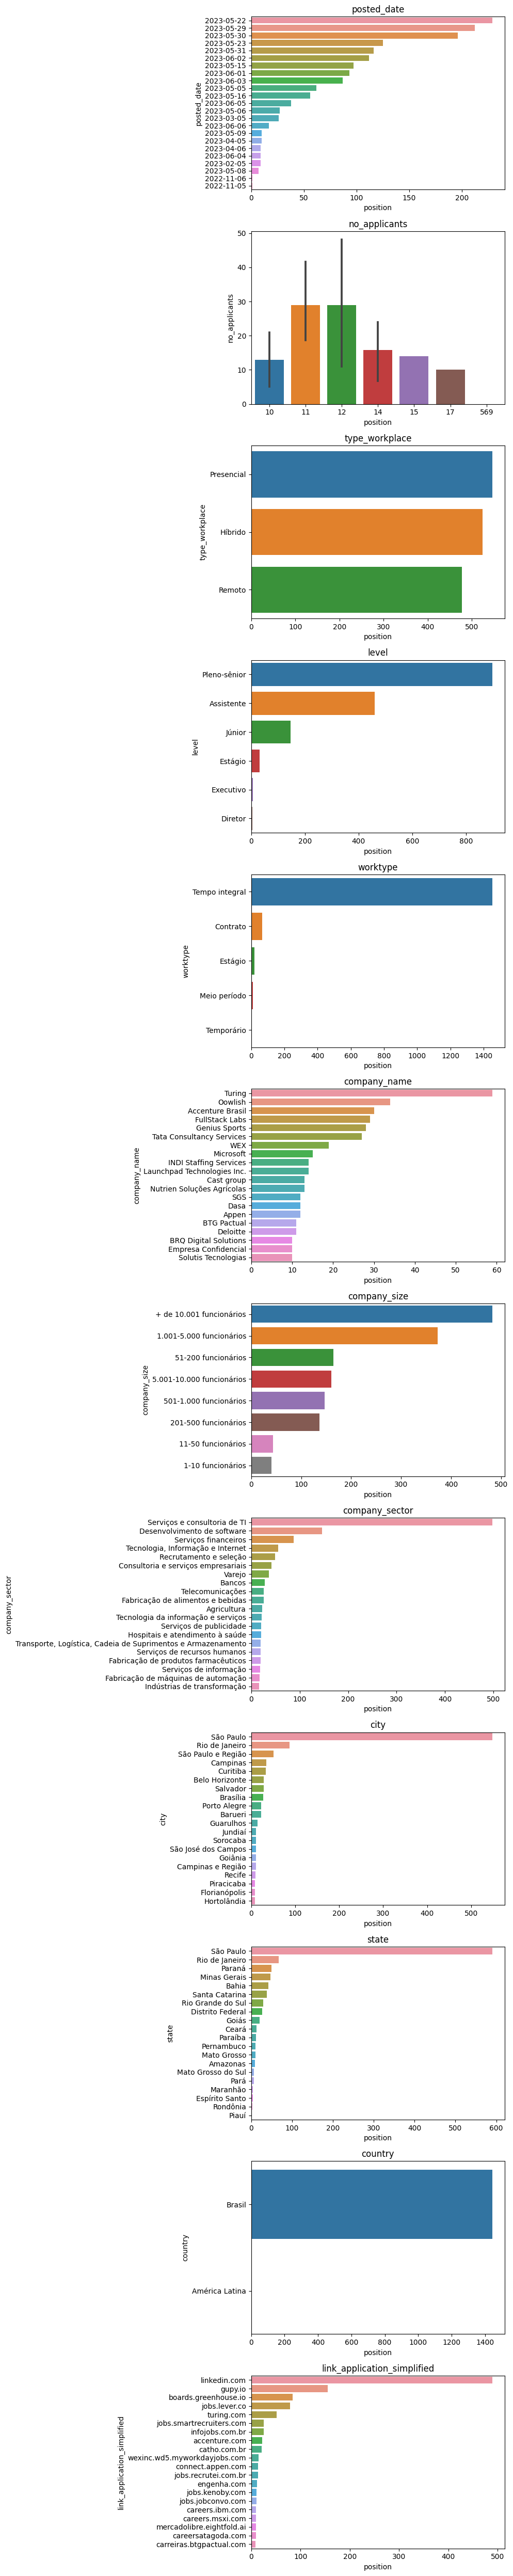

In [121]:
fig, ax = plt.subplots(len(counted_columns), 1, figsize=(10, 50))
for i, key in enumerate(counted_columns.keys()):
    if len(counted_columns[key]) > 20:
        sns.barplot(data=counted_columns[key].head(20), y=key, x='position', ax=ax[i])
    else:
        sns.barplot(data=counted_columns[key], y=key, x='position', ax=ax[i])
    ax[i].set_title(key)
sns.barplot(data=counted_columns['posted_date'], y=counted_columns['posted_date']['posted_date'].dt.strftime('%Y-%m-%d'), x='position', ax=ax[0])
fig.tight_layout()

Most of the data is more recent. That makes sense, since job offers are renovated frequently, and a lot of more old positions might not be available anymore.

<Axes: xlabel='posted_date', ylabel='no_applicants'>

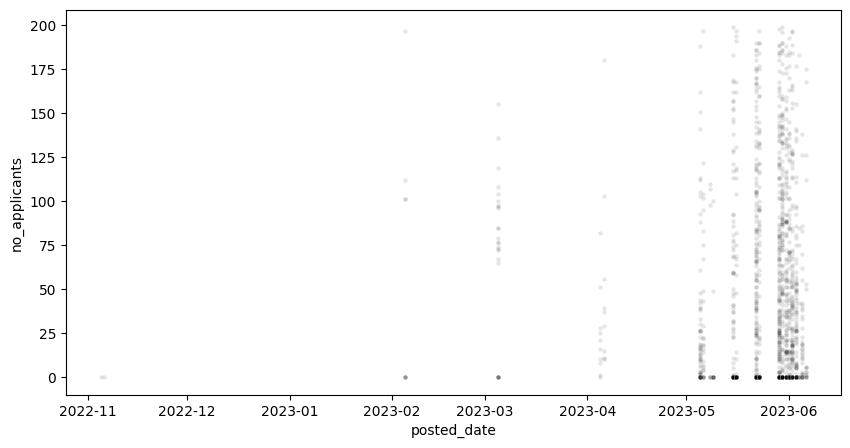

In [49]:
plt.subplots(1, 1, figsize=(10, 5))
sns.scatterplot(data=df_jobs, x='posted_date', y='no_applicants', s=10, color='black', alpha=0.1)

## Skill Exploring

In [122]:
df_exploded_skills

index                             required_skills
0          2                                    Esportes
1          2                           Futebol americano
2          2                                      Inglês
3          2                             Internet Access
4          2                           Setor de esportes
...      ...                                         ...
14425   4479                                      JQuery
14426   4479                                         MES
14427   4479                          Tecnologias da web
14428   4479                                         XML
14429   4482  SRE (Engenharia de confiabilidade do site)

[14430 rows x 2 columns]

In [51]:
counted_skills = generate_count(df_exploded_skills, 'required_skills', 'index')
counted_skills.head(10)

required_skills  index
1219  Habilidades analíticas    394
479              Comunicação    353
1320                  Inglês    329
297           Banco de dados    255
135         Análise de dados    224
2223                     SQL    219
2149  Resolução de problemas    207
1998                  Python    189
420    Ciência da computação    173
421         Ciência de dados    156

In [52]:
counted_skills = counted_skills.rename({'index':'count'}, axis=1)

<Axes: xlabel='count', ylabel='required_skills'>

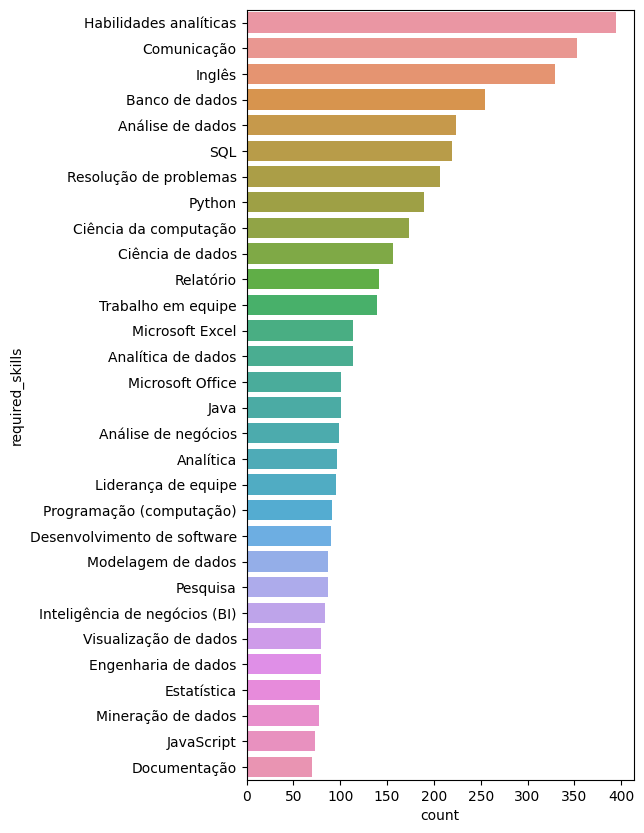

In [53]:
fig, ax = plt.subplots(figsize=(5, 10))
sns.barplot(data=counted_skills.head(30), y='required_skills', x='count', ax=ax)

In [54]:
counted_skills['count'].sum()

14430

In [55]:
len(counted_skills)

2667

In [56]:
counted_skills['percentage_count'] = counted_skills['count'] / counted_skills['count'].sum()

In [57]:
counted_skills[counted_skills['percentage_count'] > 0.01]

required_skills  count  percentage_count
1219  Habilidades analíticas    394          0.027304
479              Comunicação    353          0.024463
1320                  Inglês    329          0.022800
297           Banco de dados    255          0.017672
135         Análise de dados    224          0.015523
2223                     SQL    219          0.015177
2149  Resolução de problemas    207          0.014345
1998                  Python    189          0.013098
420    Ciência da computação    173          0.011989
421         Ciência de dados    156          0.010811

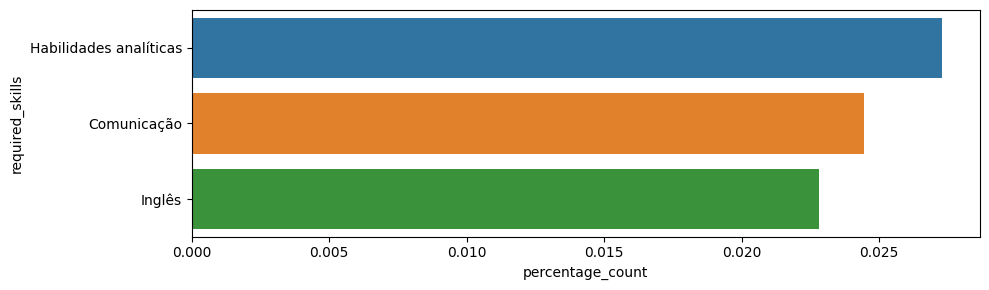

In [58]:
plt.subplots(figsize=(10,3))
sns.barplot(data=counted_skills[counted_skills['percentage_count'] > 0.02], y='required_skills', x='percentage_count')
plt.tight_layout()

## Merging dummies from skills with original dataframe

In [59]:
df_jobs_merged = pd.merge(df_jobs, pd.get_dummies(df_exploded_skills).reset_index().groupby('index').sum(), how='inner', left_index=True, right_on='index').reset_index()

In [60]:
df_jobs_merged.columns[0:20]

Index(['index', 'position', 'location', 'posted_date', 'no_applicants',
       'date_collected', 'type_workplace', 'required_skills', 'level',
       'worktype', 'description', 'link_application', 'link_linkedin',
       'company_name', 'company_size', 'company_sector', 'city', 'state',
       'country', 'link_application_simplified'],
      dtype='object')

In [61]:
df_jobs_merged.type_workplace.value_counts()

Presencial    547
Híbrido       524
Remoto        478
Name: type_workplace, dtype: int64

In [62]:
df_jobs_merged.columns[20:]

Index(['level_0', 'required_skills_.NET Core',
       'required_skills_.NET Framework', 'required_skills_24 horas',
       'required_skills_3D Math', 'required_skills_3ds Max',
       'required_skills_5G', 'required_skills_5G NR (New Radio)',
       'required_skills_5S', 'required_skills_6G',
       ...
       'required_skills_Zapier', 'required_skills_comScore',
       'required_skills_eSourcing', 'required_skills_iOS',
       'required_skills_pfSense', 'required_skills_z/OS',
       'required_skills_Água', 'required_skills_Árvores de decisão',
       'required_skills_Ética', 'required_skills_Ética profissional'],
      dtype='object', length=2668)

In [63]:
counted_columns = dict()
for col in df_jobs_merged.columns[21:]:
    counted_columns[col] = generate_count(df_jobs_merged, col, ['type_workplace'])

In [64]:
counted_columns['required_skills_Habilidades analíticas']

required_skills_Habilidades analíticas  type_workplace
0                                       0            1155
1                                       1             394

In [65]:
for skill in counted_skills.required_skills.head(20):
    print(skill)

Habilidades analíticas
Comunicação
Inglês
Banco de dados
Análise de dados
SQL
Resolução de problemas
Python
Ciência da computação
Ciência de dados
Relatório
Trabalho em equipe
Microsoft Excel
Analítica de dados
Microsoft Office
Java
Análise de negócios
Analítica
Liderança de equipe
Programação (computação)


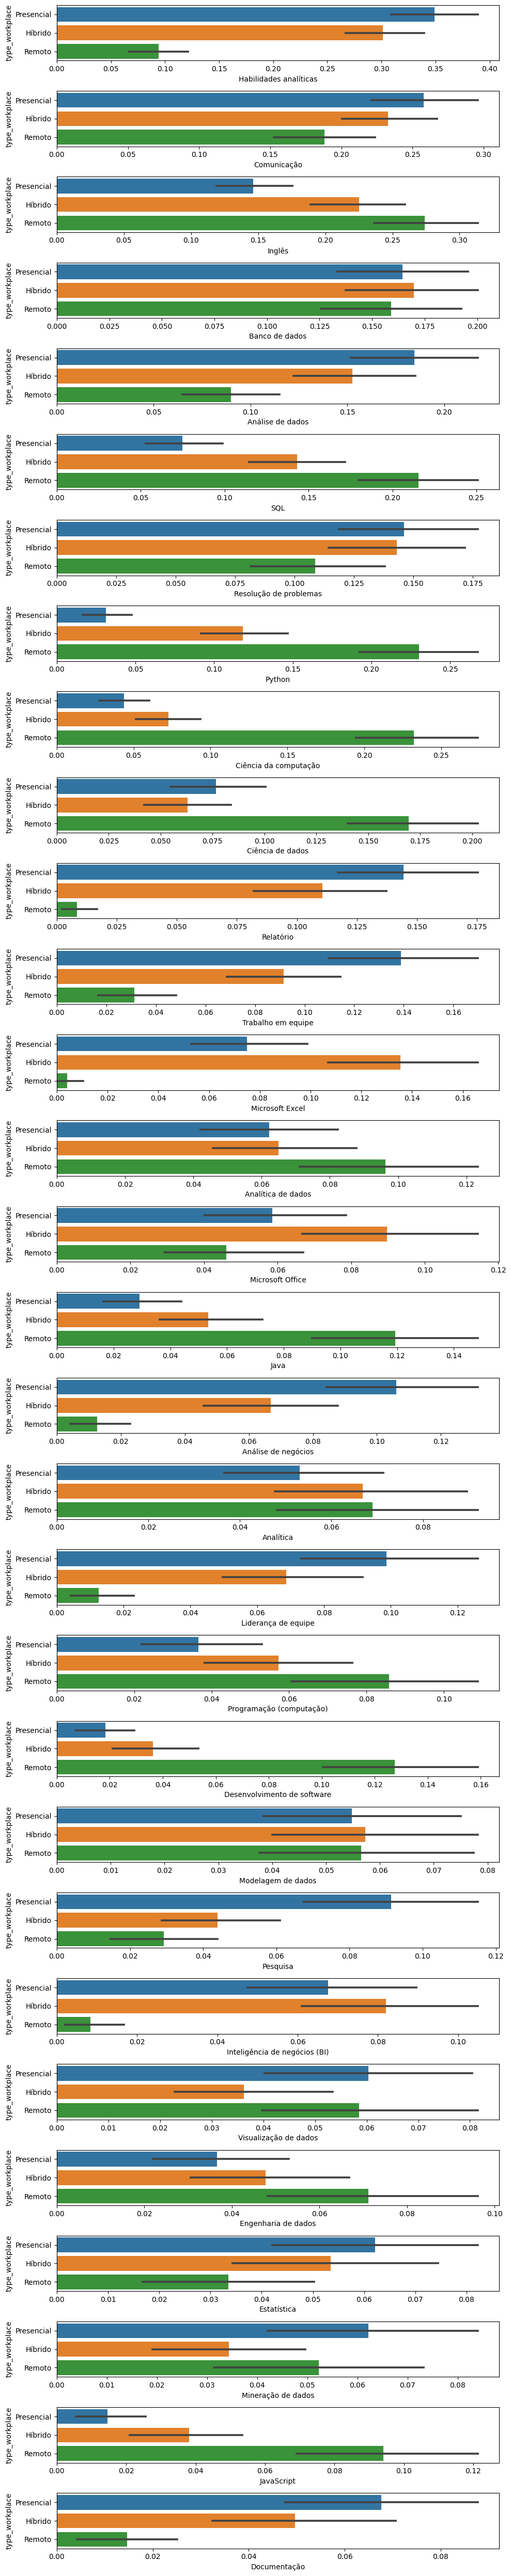

In [66]:
fig, ax = plt.subplots(30, 1, figsize=(10, 50))
for i, skill in enumerate(counted_skills.required_skills.head(30)):
    key = f'required_skills_{skill}'
    sns.barplot(data=df_jobs_merged, x=key, y='type_workplace', ax=ax[i])
    ax[i].set_xlabel(skill)

plt.tight_layout()

In [67]:
list(counted_skills.required_skills.head(500))

['Habilidades analíticas',
 'Comunicação',
 'Inglês',
 'Banco de dados',
 'Análise de dados',
 'SQL',
 'Resolução de problemas',
 'Python',
 'Ciência da computação',
 'Ciência de dados',
 'Relatório',
 'Trabalho em equipe',
 'Microsoft Excel',
 'Analítica de dados',
 'Microsoft Office',
 'Java',
 'Análise de negócios',
 'Analítica',
 'Liderança de equipe',
 'Programação (computação)',
 'Desenvolvimento de software',
 'Modelagem de dados',
 'Pesquisa',
 'Inteligência de negócios (BI)',
 'Visualização de dados',
 'Engenharia de dados',
 'Estatística',
 'Mineração de dados',
 'JavaScript',
 'Documentação',
 'ETL (Extração, transformação e carregamento)',
 'Produtos SAP',
 'Dashboards',
 'Benefícios de funcionários',
 'Solução de problemas técnicos',
 'Linguagens de programação',
 'Apresentações',
 'Indicadores-chave de desempenho',
 'MySQL',
 'Aprendizado de máquina',
 'NoSQL',
 'Treinamento',
 'Linux',
 'CSS',
 'Amazon Web Services',
 'Economia',
 'Processamento de linguagem natural (PLN

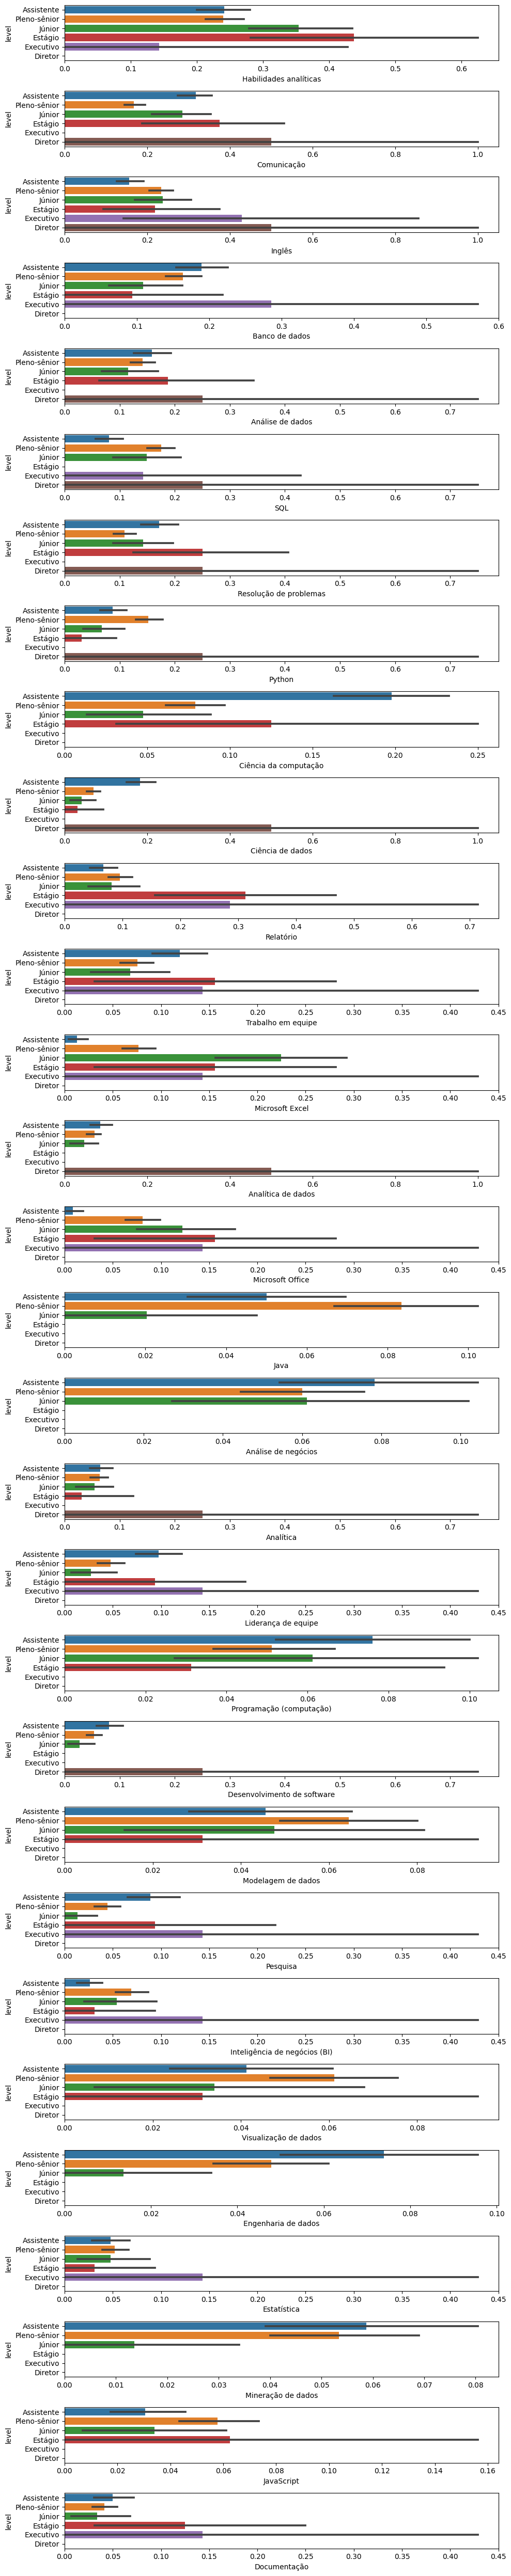

In [68]:
fig, ax = plt.subplots(30, 1, figsize=(10, 50))
for i, skill in enumerate(counted_skills.required_skills.head(30)):
    key = f'required_skills_{skill}'
    sns.barplot(data=df_jobs_merged, x=key, y='level', ax=ax[i])
    ax[i].set_xlabel(skill)

plt.tight_layout()

In [2]:
first_dict = {
    'Habilidades analíticas': [
        'Análise de dados',
        'Análise de negócios',
        'Analítica de dados',
        'Analítica',
        'Modelagem de dados',
        'Mineração de dados',
        'Inteligência de negócios (BI)',
        'Inteligência artificial',
        'Análise estatística',
        'Análise de dados estatísticos',
        'Análise financeira',
        'Análise estatística',
        'Análise de produtos',
        'Análise de problemas',
        'Análise técnica',
        'Pesquisa qualitativa',
        'Pesquisa de mercado',
        'Análise de marketing',
        'Análise de riscos',
        'Análise de séries temporais',
        'Geração de insights'
    ],
    'Comunicação': [
        'Comunicação',
        'Comunicação interpessoal',
        'Comunicação oral',
        'Comunicação escrita',
        'Articulação (TI)',
        'Argumentation',
        'Coordenação de projetos',
        'Condução de reuniões',
        'Anotações',
        'Oratória',
        'Demonstração de produtos',
        'Relações públicas'
    ],
    'Linguagens de programação': [
        'SQL',
        'Python',
        'Java',
        'JavaScript',
        'C#',
        'HTML',
        'CSS',
        'TypeScript',
        'Scala',
        'C (linguagem de programação)',
        'C++',
        'Ruby',
        'Swift (Linguagem de programação)',
        'Go (Linguagem de programação)',
        'PL/SQL',
        'R (linguagem de programação)',
        'ABAP',
        'Shell script',
        'JQuery',
        'VBA (Visual Basic for Applications)'
    ],
    'Tecnologias e ferramentas': [
        'Banco de dados',
        'Microsoft Excel',
        'Microsoft Office',
        'Microsoft PowerPoint',
        'Programação (computação)',
        'Desenvolvimento de software',
        'Produtos SAP',
        'ETL (Extração, transformação e carregamento)',
        'Dashboards',
        'MySQL',
        'NoSQL',
        'Linux',
        'Amazon Web Services',
        'Processamento de linguagem natural (PLN)',
        'Kubernetes',
        'Django',
        'Windows Azure',
        'Git',
        'Metodologias Agile',
        'Google Cloud Platform (GCP)',
        'DevOps',
        'Microsoft SQL Server',
        'Docker',
        'Microsoft Power BI',
        'Banco de dados Oracle',
        'MongoDB',
        'Tableau',
        'Apache Spark',
        'Apache Kafka',
        'PostgreSQL',
        'Spring Framework',
        'Amazon RDS',
        'Looker (Software)',
        'SAS',
        'Firewalls',
        'GoldMine (CRM)',
        'Salesforce.com',
        'GitLab',
        'Ansible',
        'Redis',
        'Azure Data Factory',
        'Terraform',
        'Dynatrace',
        'Azure Databricks',
        'Azure DevOps',
        'OpenCV',
        'Microsoft Visual Studio',
        'Jupyter Notebook',
        'Elasticsearch',
        'Kibana',
        'Grafana',
        'Prometheus',
        'Hadoop',
        'Hive (software)',
        'Impala (software)',
        'Presto (software)',
        'Airflow (software)',
        'Keras',
        'PyTorch',
        'TensorFlow',
        'Node.js'
    ]}

In [3]:
second_dict = {
    'Habilidades analíticas': [
        'Resolução de problemas', 'Ciência da computação', 'Ciência de dados',
        'Visualização de dados', 'Engenharia de dados', 'Estatística', 'Benefícios de funcionários',
        'Indicadores-chave de desempenho', 'Economia', 'Padrões de design', 'Programação orientada a objetos (POO)',
        'Negociação', 'Gestão de projetos', 'Finanças', 'Melhoria de processos', 'Manipulação de dados',
        'Capacidade analítica', 'Análise de sistemas', 'Otimização', 'Desenvolvimento de relatório', 'Big data',
        'Programação de linguagem de consulta', 'Gestão de dados', 'Planejamento', 'Administração',
        'Competências interpessoais', 'Tomada de decisão', 'Capacidade de organização', 'Engenharia',
        'Litígios', 'Planos de ação', 'Modelos de dados', 'Governança de dados', 'Estudos de casos',
        'Processos empresariais', 'Orçamento', 'DAX (Expressões de análise de dados)', 'ITIL',
        'Integração contínua', 'Snowflake', 'ERP (Planejamento de recursos empresariais)', 'Desenvolvimento de front-end',
        'Processamento de dados', 'Planejamento de testes', 'Implementação de projetos', 'Ciclo de vida de sistemas de informação',
        'Teste de unidade', 'Revisão de código', 'Arquitetura de dados', 'Qualidade dos dados', 'Scrum',
        'Satisfação do cliente', 'Design de software', 'Documentação técnica', 'Inteligência de mercado',
        'Aprendizagem profunda', 'Operações', 'Compras', 'Planejamento estratégico', 'Selenium',
        'Controle interno', 'NumPy', 'Arquitetura técnica', 'Modelagem estatística', 'Processamento de imagem',
        'Engenharia de Computação', 'Liderança', 'Hive', 'Melhoria contínua', 'Cucumber', 'Gestão de produtos',
        'Resposta a incidentes', 'Ruby on Rails', 'Desenvolvimento de soluções', 'Impostos', 'Histórias de usuários',
        'Analítica preditiva', 'MRP (Planejamento das necessidades de materiais)', 'Engajamento de clientes',
        'Arquitetura de soluções', 'ServiceNow', 'Algoritmos', 'Procedimentos armazenados', 'Setor público'
    ],
    'Comunicação': [
        'Inglês', 'Relatório', 'Trabalho em equipe', 'Apresentações', 'Documentação', 'Instrução',
        'Benefícios de funcionários', 'Vendas', 'Marketing', 'Criação de relacionamentos', 'Insights de negócios',
        'Relacionamentos interpessoais', 'Promoção da inclusão', 'Satisfação do cliente', 'Resposta a incidentes',
        'Recursos humanos (RH)', 'Propaganda comercial'
    ],
    'Linguagens de programação': [
        'Linguagens de programação', 'React.js', 'PySpark', '.NET Framework', 'XML', 'Angular (Framework)',
        'Android', 'JSON', 'PHP', 'Ruby on Rails', 'Kotlin'
    ],
    'Tecnologias e ferramentas': [
        'Computação em nuvem', 'Internet Access', 'Skype', 'YouTube', 'Snowflake', 'Google Analytics', 'Office 365',
        'JIRA', 'Microsoft Windows', 'iOS', 'Controle de versão', 'Segurança da informação', 'Teste de software',
        'Selenium', 'ServiceNow'
    ]
}

In [4]:
third_dict = {
    'Habilidades analíticas': [
        'Solução de problemas técnicos', 'Pesquisa', 'Aprendizado de máquina', 'Matemática',
        'Pensamento crítico', 'Requisitos de negócio', 'Estruturas de dados',
        'Reconhecimento de padrões', 'Data warehouse', 'Levantamento de requisitos', 'Garantia de qualidade',
        'Controle de qualidade', 'Contabilidade', 'Análise de causa raiz (RCA)', 'Datasets', 
        'Contabilidade estatuária', 'Limpeza de dados', 'Análise de requisitos', 'Teste A/B', 
        'Root Cause', 'Teste de aceitação de usuários', 'Execução de testes', 'Privacidade dos dados', 
        'Relatórios empresarias', 'Controle de inventário', 'Estoque', 'Demonstrações financeiras', 
        'Detecção de objetos', 'Sistema ERP (SIGE)', 'SGBD', 'Pipeline de dados', 'Preparação de dados', 
        'Capacidade de adaptação', 'Planejamento de demanda', 'Contas a pagar', 'Testes funcionais', 
        'Teste de regressão', 'Teste de integração', 'Automação de testes', 'Validação de dados'
    ],
    'Comunicação': [
        'Comunicação social', 'Treinamento', 'Coaching', 'Gestão de incidentes', 'Experiência do usuário (UX)',
        'Web Design Responsivo', 'Relacionamento com clientes', 'Satisfação do cliente', 'Engajamento de clientes',
        'Experiência do cliente', 'Relacionamento como cliente', 'Gestão de contas', 'Vendas', 'Atendimento ao cliente',
        'Sucesso do cliente', 'CRM', 'Marketing', 'Marketing digital', 'SEO', 'Publicidade', 'E-mail marketing',
        'Marketing de conteúdo', 'Marketing de mídia social', 'Marketing de busca', 'Marketing de marca',
        'Marketing estratégico', 'Gestão de projetos', 'Planejamento de projetos', 'Gestão de projetos ágeis',
        'Gestão de equipes de projeto', 'Gerenciamento de riscos', 'Gerenciamento de tempo', 'Gerenciamento de recursos',
        'Gerenciamento de custos', 'Design thinking', 'UI/UX Design', 'Design de interface do usuário',
        'Design de experiência do usuário', 'Design de experiência do cliente', 'Design de marca'
    ],
    'Linguagens de programação': [
        'Desenvolvimento de back-end', 'Desenvolvimento de sistemas', 'Desenvolvimento de aplicativos móveis',
        'Desenvolvimento orientado ao comportamento', 'Desenvolvimento de soluções', 'Desenvolvimento de front-end',
        'API REST', 'Technical Specs', 'Planilhas Google', '.NET Core', 'Spring Boot', 'Spring Data',
        'Desenvolvimento Android', 'WordPress'
    ],
    'Tecnologias e ferramentas': [
        'Automação', 'Suporte técnico', 'Interface de programação de aplicativos (API)', 'Sistemas operacionais',
        'Segurança da informação', 'Teste de software', 'Comércio eletrônico', 'Implementação SAP', 'Auditoria',
        'SDLC (Ciclo de vida do desenvolvimento de software)', 'Pipeline de dados', 'Container Orchestration',
        'Bancos de dados relacionais', 'SQL Server Analysis Services (SSAS)', 'Active Directory',
        'Implantação de software', 'Visualização', 'Fontes tipográficas', 'Airflow', 'Contas a receber',
        'Administração de sistemas', 'Administração de sistemas Linux', 'Servidor Windows', 'Integração', 'Arquitetura',
        'Arquitetura de software', 'Análise financeira', 'Gestão financeira', 'Contabilidade', 'Orçamento',
        'Planejamento financeiro', 'Modelagem financeira', 'Análise de investimentos', 'Gestão de tesouraria',
        'Auditoria interna', 'Análise de risco financeiro', 'Controle financeiro', 'Gestão de ativos',
        'Relatórios financeiros', 'Finanças corporativas', 'M&A', 'Fundos de investimento', 'Design gráfico', 'Design de interiores', 'Desenvolvimento web', 'Desenvolvimento de aplicativos móveis', 'Desenvolvimento de jogos', 'Desenvolvimento de software',
        'Ferramentas de produtividade', 'Ferramentas de análise de dados', 'Ferramentas de visualização de dados',
        'Plataformas de nuvem', 'Redes de computadores', 'Administração de redes', 'Armazenamento de dados',
        'Big Data', 'Ciência de dados', 'Aprendizado de máquina', 'Inteligência artificial', 'Deep Learning',
        'Processamento de linguagem natural (PLN)', 'Visão computacional', 'Ferramentas de modelagem',
        'Ferramentas de simulação', 'Ferramentas de colaboração', 'Ferramentas de gerenciamento de projetos',
        'Ferramentas de controle de versão', 'Ferramentas de automação de processos', 'Automação de marketing',
        'Automação de vendas', 'Automação de atendimento ao cliente', 'Chatbots', 'Robótica', 'IoT'
    ]
}

In [5]:
for key in second_dict:
    first_dict[key].extend(second_dict[key])

In [6]:
for key in second_dict:
    first_dict[key].extend(third_dict[key])

In [7]:
print(first_dict)

{'Habilidades analíticas': ['Análise de dados', 'Análise de negócios', 'Analítica de dados', 'Analítica', 'Modelagem de dados', 'Mineração de dados', 'Inteligência de negócios (BI)', 'Inteligência artificial', 'Análise estatística', 'Análise de dados estatísticos', 'Análise financeira', 'Análise estatística', 'Análise de produtos', 'Análise de problemas', 'Análise técnica', 'Pesquisa qualitativa', 'Pesquisa de mercado', 'Análise de marketing', 'Análise de riscos', 'Análise de séries temporais', 'Geração de insights', 'Resolução de problemas', 'Ciência da computação', 'Ciência de dados', 'Visualização de dados', 'Engenharia de dados', 'Estatística', 'Benefícios de funcionários', 'Indicadores-chave de desempenho', 'Economia', 'Padrões de design', 'Programação orientada a objetos (POO)', 'Negociação', 'Gestão de projetos', 'Finanças', 'Melhoria de processos', 'Manipulação de dados', 'Capacidade analítica', 'Análise de sistemas', 'Otimização', 'Desenvolvimento de relatório', 'Big data', 'P

In [75]:
def classify_skills(skill):
    classified_skills = {'Habilidades analíticas': ['Análise de dados', 'Análise de negócios', 'Analítica de dados', 'Analítica', 'Modelagem de dados', 'Mineração de dados', 'Inteligência de negócios (BI)', 'Inteligência artificial', 'Análise estatística', 'Análise de dados estatísticos', 'Análise financeira', 'Análise estatística', 'Análise de produtos', 'Análise de problemas', 'Análise técnica', 'Pesquisa qualitativa', 'Pesquisa de mercado', 'Análise de marketing', 'Análise de riscos', 'Análise de séries temporais', 'Geração de insights', 'Resolução de problemas', 'Ciência da computação', 'Ciência de dados', 'Visualização de dados', 'Engenharia de dados', 'Estatística', 'Benefícios de funcionários', 'Indicadores-chave de desempenho', 'Economia', 'Padrões de design', 'Programação orientada a objetos (POO)', 'Negociação', 'Gestão de projetos', 'Finanças', 'Melhoria de processos', 'Manipulação de dados', 'Capacidade analítica', 'Análise de sistemas', 'Otimização', 'Desenvolvimento de relatório', 'Big data', 'Programação de linguagem de consulta', 'Gestão de dados', 'Planejamento', 'Administração', 'Competências interpessoais', 'Tomada de decisão', 'Capacidade de organização', 'Engenharia', 'Litígios', 'Planos de ação', 'Modelos de dados', 'Governança de dados', 'Estudos de casos', 'Processos empresariais', 'Orçamento', 'DAX (Expressões de análise de dados)', 'ITIL', 'Integração contínua', 'Snowflake', 'ERP (Planejamento de recursos empresariais)', 'Desenvolvimento de front-end', 'Processamento de dados', 'Planejamento de testes', 'Implementação de projetos', 'Ciclo de vida de sistemas de informação', 'Teste de unidade', 'Revisão de código', 'Arquitetura de dados', 'Qualidade dos dados', 'Scrum', 'Satisfação do cliente', 'Design de software', 'Documentação técnica', 'Inteligência de mercado', 'Aprendizagem profunda', 'Operações', 'Compras', 'Planejamento estratégico', 'Selenium', 'Controle interno', 'NumPy', 'Arquitetura técnica', 'Modelagem estatística', 'Processamento de imagem', 'Engenharia de Computação', 'Liderança', 'Hive', 'Melhoria contínua', 'Cucumber', 'Gestão de produtos', 'Resposta a incidentes', 'Ruby on Rails', 'Desenvolvimento de soluções', 'Impostos', 'Histórias de usuários', 'Analítica preditiva', 'MRP (Planejamento das necessidades de materiais)', 'Engajamento de clientes', 'Arquitetura de soluções', 'ServiceNow', 'Algoritmos', 'Procedimentos armazenados', 'Setor público', 'Solução de problemas técnicos', 'Pesquisa', 'Aprendizado de máquina', 'Matemática', 'Pensamento crítico', 'Requisitos de negócio', 'Estruturas de dados', 'Reconhecimento de padrões', 'Data warehouse', 'Levantamento de requisitos', 'Garantia de qualidade', 'Controle de qualidade', 'Contabilidade', 'Análise de causa raiz (RCA)', 'Datasets', 'Contabilidade estatuária', 'Limpeza de dados', 'Análise de requisitos', 'Teste A/B', 'Root Cause', 'Teste de aceitação de usuários', 'Execução de testes', 'Privacidade dos dados', 'Relatórios empresarias', 'Controle de inventário', 'Estoque', 'Demonstrações financeiras', 'Detecção de objetos', 'Sistema ERP (SIGE)', 'SGBD', 'Pipeline de dados', 'Preparação de dados', 'Capacidade de adaptação', 'Planejamento de demanda', 'Contas a pagar', 'Testes funcionais', 'Teste de regressão', 'Teste de integração', 'Automação de testes', 'Validação de dados'], 'Comunicação': ['Comunicação', 'Comunicação interpessoal', 'Comunicação oral', 'Comunicação escrita', 'Articulação (TI)', 'Argumentation', 'Coordenação de projetos', 'Condução de reuniões', 'Anotações', 'Oratória', 'Demonstração de produtos', 'Relações públicas', 'Inglês', 'Relatório', 'Trabalho em equipe', 'Apresentações', 'Documentação', 'Instrução', 'Benefícios de funcionários', 'Vendas', 'Marketing', 'Criação de relacionamentos', 'Insights de negócios', 'Relacionamentos interpessoais', 'Promoção da inclusão', 'Satisfação do cliente', 'Resposta a incidentes', 'Recursos humanos (RH)', 'Propaganda comercial', 'Comunicação social', 'Treinamento', 'Coaching', 'Gestão de incidentes', 'Experiência do usuário (UX)', 'Web Design Responsivo', 'Relacionamento com clientes', 'Satisfação do cliente', 'Engajamento de clientes', 'Experiência do cliente', 'Relacionamento como cliente', 'Gestão de contas', 'Vendas', 'Atendimento ao cliente', 'Sucesso do cliente', 'CRM', 'Marketing', 'Marketing digital', 'SEO', 'Publicidade', 'E-mail marketing', 'Marketing de conteúdo', 'Marketing de mídia social', 'Marketing de busca', 'Marketing de marca', 'Marketing estratégico', 'Gestão de projetos', 'Planejamento de projetos', 'Gestão de projetos ágeis', 'Gestão de equipes de projeto', 'Gerenciamento de riscos', 'Gerenciamento de tempo', 'Gerenciamento de recursos', 'Gerenciamento de custos', 'Design thinking', 'UI/UX Design', 'Design de interface do usuário', 'Design de experiência do usuário', 'Design de experiência do cliente', 'Design de marca'], 'Linguagens de programação': ['SQL', 'Python', 'Java', 'JavaScript', 'C#', 'HTML', 'CSS', 'TypeScript', 'Scala', 'C (linguagem de programação)', 'C++', 'Ruby', 'Swift (Linguagem de programação)', 'Go (Linguagem de programação)', 'PL/SQL', 'R (linguagem de programação)', 'ABAP', 'Shell script', 'JQuery', 'VBA (Visual Basic for Applications)', 'Linguagens de programação', 'React.js', 'PySpark', '.NET Framework', 'XML', 'Angular (Framework)', 'Android', 'JSON', 'PHP', 'Ruby on Rails', 'Kotlin', 'Desenvolvimento de back-end', 'Desenvolvimento de sistemas', 'Desenvolvimento de aplicativos móveis', 'Desenvolvimento orientado ao comportamento', 'Desenvolvimento de soluções', 'Desenvolvimento de front-end', 'API REST', 'Technical Specs', 'Planilhas Google', '.NET Core', 'Spring Boot', 'Spring Data', 'Desenvolvimento Android', 'WordPress'], 'Tecnologias e ferramentas': ['Banco de dados', 'Microsoft Excel', 'Microsoft Office', 'Microsoft PowerPoint', 'Programação (computação)', 'Desenvolvimento de software', 'Produtos SAP', 'ETL (Extração, transformação e carregamento)', 'Dashboards', 'MySQL', 'NoSQL', 'Linux', 'Amazon Web Services', 'Processamento de linguagem natural (PLN)', 'Kubernetes', 'Django', 'Windows Azure', 'Git', 'Metodologias Agile', 'Google Cloud Platform (GCP)', 'DevOps', 'Microsoft SQL Server', 'Docker', 'Microsoft Power BI', 'Banco de dados Oracle', 'MongoDB', 'Tableau', 'Apache Spark', 'Apache Kafka', 'PostgreSQL', 'Spring Framework', 'Amazon RDS', 'Looker (Software)', 'SAS', 'Firewalls', 'GoldMine (CRM)', 'Salesforce.com', 'GitLab', 'Ansible', 'Redis', 'Azure Data Factory', 'Terraform', 'Dynatrace', 'Azure Databricks', 'Azure DevOps', 'OpenCV', 'Microsoft Visual Studio', 'Jupyter Notebook', 'Elasticsearch', 'Kibana', 'Grafana', 'Prometheus', 'Hadoop', 'Hive (software)', 'Impala (software)', 'Presto (software)', 'Airflow (software)', 'Keras', 'PyTorch', 'TensorFlow', 'Node.js', 'Computação em nuvem', 'Internet Access', 'Skype', 'YouTube', 'Snowflake', 'Google Analytics', 'Office 365', 'JIRA', 'Microsoft Windows', 'iOS', 'Controle de versão', 'Segurança da informação', 'Teste de software', 'Selenium', 'ServiceNow', 'Automação', 'Suporte técnico', 'Interface de programação de aplicativos (API)', 'Sistemas operacionais', 'Segurança da informação', 'Teste de software', 'Comércio eletrônico', 'Implementação SAP', 'Auditoria', 'SDLC (Ciclo de vida do desenvolvimento de software)', 'Pipeline de dados', 'Container Orchestration', 'Bancos de dados relacionais', 'SQL Server Analysis Services (SSAS)', 'Active Directory', 'Implantação de software', 'Visualização', 'Fontes tipográficas', 'Airflow', 'Contas a receber', 'Administração de sistemas', 'Administração de sistemas Linux', 'Servidor Windows', 'Integração', 'Arquitetura', 'Arquitetura de software', 'Análise financeira', 'Gestão financeira', 'Contabilidade', 'Orçamento', 'Planejamento financeiro', 'Modelagem financeira', 'Análise de investimentos', 'Gestão de tesouraria', 'Auditoria interna', 'Análise de risco financeiro', 'Controle financeiro', 'Gestão de ativos', 'Relatórios financeiros', 'Finanças corporativas', 'M&A', 'Fundos de investimento', 'Design gráfico', 'Design de interiores', 'Desenvolvimento web', 'Desenvolvimento de aplicativos móveis', 'Desenvolvimento de jogos', 'Desenvolvimento de software', 'Ferramentas de produtividade', 'Ferramentas de análise de dados', 'Ferramentas de visualização de dados', 'Plataformas de nuvem', 'Redes de computadores', 'Administração de redes', 'Armazenamento de dados', 'Big Data', 'Ciência de dados', 'Aprendizado de máquina', 'Inteligência artificial', 'Deep Learning', 'Processamento de linguagem natural (PLN)', 'Visão computacional', 'Ferramentas de modelagem', 'Ferramentas de simulação', 'Ferramentas de colaboração', 'Ferramentas de gerenciamento de projetos', 'Ferramentas de controle de versão', 'Ferramentas de automação de processos', 'Automação de marketing', 'Automação de vendas', 'Automação de atendimento ao cliente', 'Chatbots', 'Robótica', 'IoT']}

    for key in classified_skills:
        if skill in classified_skills[key]:
            return key

counted_skills['category'] = counted_skills.required_skills.map(classify_skills)


In [76]:
counted_skills[counted_skills['category'].isna()]['required_skills'][:200].values

array(['Habilidades analíticas', 'Liderança de equipe',
       'Tecnologia da informação', 'Táticas', 'Esportes', 'Espanhol',
       'Futebol americano', 'Acompanhamento (follow up)',
       'Corte em cubos', 'Setor de esportes', 'SSIS', 'Coleta de dados',
       'Atenção a detalhes', 'Microsserviços', 'Redação',
       'Linhas de produção', 'Gestão logística',
       'Integração e entrega contínuas (CI/CD)',
       'REST (Transferência de estado representacional )', 'Comércio',
       'Resolving Issues', 'Cursos', 'Planilha eletrônica',
       'Clientes internos', 'Infraestrutura de nuvem', 'Negócios',
       'Português', 'Aplicativos web', 'Gestão de equipes',
       'Testes manuais', 'Suporte ao cliente',
       'Administração de empresas', 'Confiabilidade', 'Software',
       'Cobrança de contas a receber', 'Desvios', 'Treatment',
       'Projeções', 'Graduate Entry',
       'Gestão de relacionamento com o cliente (CRM)', 'Fluxo de dados',
       'Campanhas', 'Seguros', 'Microsoft 

In [77]:
sum_categories = counted_skills.groupby('category')[['count', 'percentage_count']].sum().reset_index()

<Axes: xlabel='percentage_count', ylabel='category'>

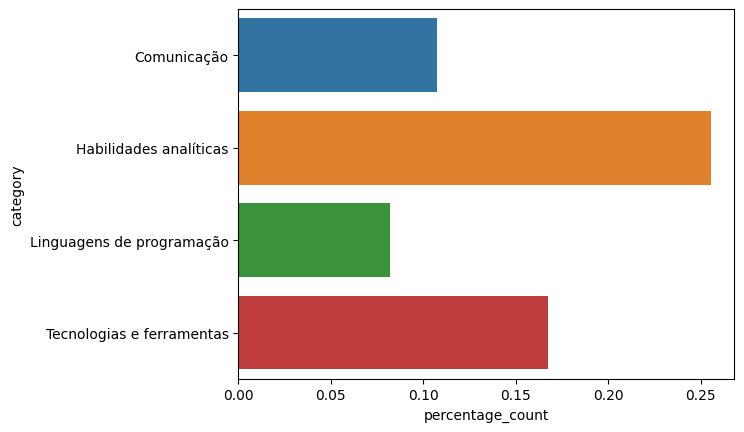

In [78]:
sns.barplot(data=sum_categories, x='percentage_count', y='category')

In [79]:
counted_skills[counted_skills['category'] == 'Linguagens de programação'].head(25)

required_skills  count  percentage_count  \
2223                           SQL    219          0.015177   
1998                        Python    189          0.013098   
1393                          Java    101          0.006999   
1394                    JavaScript     73          0.005059   
1435     Linguagens de programação     59          0.004089   
362                            CSS     40          0.002772   
345                             C#     36          0.002495   
680    Desenvolvimento de back-end     35          0.002426   
2049                      React.js     28          0.001940   
2649                           XML     26          0.001802   
1                   .NET Framework     25          0.001733   
1995                       PySpark     24          0.001663   
1214                          HTML     24          0.001663   
2243                         Scala     21          0.001455   
2391                   Spring Boot     21          0.001455   
344   C (linguagem de programação)     20          0.001386   
346                            C++     20          0.001386   
121            Angular (Framework)     15          0.001040   
116                        Android     15          0.001040   
2547                    TypeScript     14          0.000970   
1752                        PL/SQL     12          0.000832   
1388                          JSON     11          0.000762   
2026  R (linguagem de programação)     11          0.000762   
703    Desenvolvimento de sistemas     10          0.000693   
10                            ABAP     10          0.000693   

                       category  
2223  Linguagens de programação  
1998  Linguagens de programação  
1393  Linguagens de programação  
1394  Linguagens de programação  
1435  Linguagens de programação  
362   Linguagens de programação  
345   Linguagens de programação  
680   Linguagens de programação  
2049  Linguagens de programação  
2649  Linguagens de programação  
1     Linguagens de programação  
1995  Linguagens de programação  
1214  Linguagens de programação  
2243  Linguagens de programação  
2391  Linguagens de programação  
344   Linguagens de programação  
346   Linguagens de programação  
121   Linguagens de programação  
116   Linguagens de programação  
2547  Linguagens de programação  
1752  Linguagens de programação  
1388  Linguagens de programação  
2026  Linguagens de programação  
703   Linguagens de programação  
10    Linguagens de programação

In [ ]:
counted_columns[col] = generate_count(df_jobs_merged, col, ['position'])

In [90]:
list_top_20_companies = list(df_jobs_merged.company_name.value_counts()[:20].reset_index()['index'])
list_top_20_companies

['Turing',
 'Oowlish',
 'Accenture Brasil',
 'FullStack Labs',
 'Genius Sports',
 'Tata Consultancy Services',
 'WEX',
 'Microsoft',
 'Launchpad Technologies Inc.',
 'INDI Staffing Services',
 'Nutrien Soluções Agrícolas',
 'Cast group',
 'SGS',
 'Appen',
 'Dasa',
 'BTG Pactual',
 'Deloitte',
 'Empresa Confidencial',
 'Solutis Tecnologias',
 'BRQ Digital Solutions']

In [156]:
col_required_skills = df_jobs_merged.columns[21:]
col_required_skills

Index(['required_skills_.NET Core', 'required_skills_.NET Framework',
       'required_skills_24 horas', 'required_skills_3D Math',
       'required_skills_3ds Max', 'required_skills_5G',
       'required_skills_5G NR (New Radio)', 'required_skills_5S',
       'required_skills_6G', 'required_skills_802.1x',
       ...
       'required_skills_Zapier', 'required_skills_comScore',
       'required_skills_eSourcing', 'required_skills_iOS',
       'required_skills_pfSense', 'required_skills_z/OS',
       'required_skills_Água', 'required_skills_Árvores de decisão',
       'required_skills_Ética', 'required_skills_Ética profissional'],
      dtype='object', length=2667)

In [176]:
agg_col_required_skills = {col: 'sum' for col in col_required_skills}
agg_col_required_skills['position'] = 'count'
col_required_skills = col_required_skills.insert(0, 'position')


In [180]:
grouped_companies = df_jobs_merged.groupby('company_name')[col_required_skills].agg(agg_col_required_skills).reset_index().sort_values(by='position', ascending=False).reset_index()

In [181]:
grouped_companies[grouped_companies['company_name'] == 'Turing']

index company_name  required_skills_.NET Core  \
0    617       Turing                          0   

   required_skills_.NET Framework  required_skills_24 horas  \
0                               0                         0   

   required_skills_3D Math  required_skills_3ds Max  required_skills_5G  \
0                        0                        0                   0   

   required_skills_5G NR (New Radio)  required_skills_5S  ...  \
0                                  0                   0  ...   

   required_skills_comScore  required_skills_eSourcing  required_skills_iOS  \
0                         0                          0                    1   

   required_skills_pfSense  required_skills_z/OS  required_skills_Água  \
0                        0                     0                     0   

   required_skills_Árvores de decisão  required_skills_Ética  \
0                                   0                      0   

   required_skills_Ética profissional  position  
0                                   0        59  

[1 rows x 2670 columns]

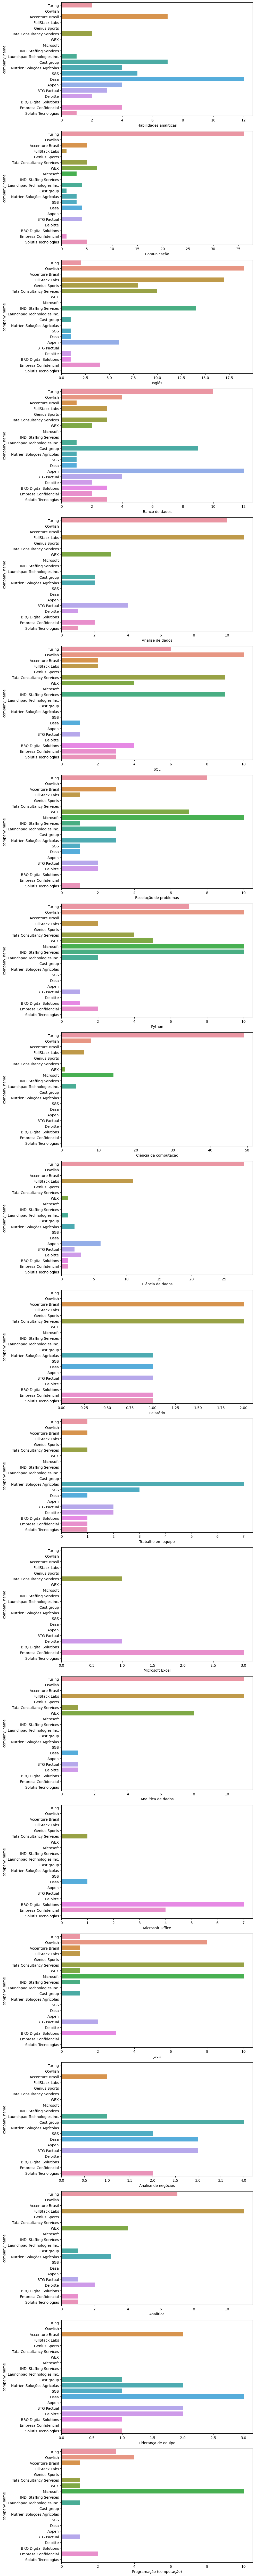

In [185]:
fig, ax = plt.subplots(20, 1, figsize=(10, 100))
for i, skill in enumerate(counted_skills.required_skills.head(20)):
    key = f'required_skills_{skill}'
    sns.barplot(data=grouped_companies.head(20), x=grouped_companies[key], y='company_name', ax=ax[i])
    ax[i].set_xlabel(skill)

plt.tight_layout()

In [193]:
for company in grouped_companies.company_name[:20]:
    print(company)

Turing
Oowlish
Accenture Brasil
FullStack Labs
Genius Sports
Tata Consultancy Services
WEX
Microsoft
INDI Staffing Services
Launchpad Technologies Inc.
Cast group
Nutrien Soluções Agrícolas
SGS
Dasa
Appen
BTG Pactual
Deloitte
BRQ Digital Solutions
Empresa Confidencial
Solutis Tecnologias


In [216]:
mask_not_0 = grouped_companies != 0
mask_turing = grouped_companies['company_name'] == 'Turing'

In [247]:
list_dfs_top_companies = []
for company in grouped_companies.company_name[:20]:
    mask = grouped_companies['company_name'] == company
    list_dfs_top_companies.append(grouped_companies.loc[mask, ~(grouped_companies[mask] == 0).any()].melt(id_vars=['index', 'company_name', 'position']).sort_values(by='value', ascending=False).head(5))

#sns.barplot(data=grouped_companies.loc[mask_turing, ~(grouped_companies[mask_turing] == 0).any()].melt(id_vars=['index', 'company_name', 'position']).sort_values(by='value', ascending=False).head(5), y='variable', x='value')

In [265]:
list_dfs_top_companies[0].iloc[1, 1]

'Turing'

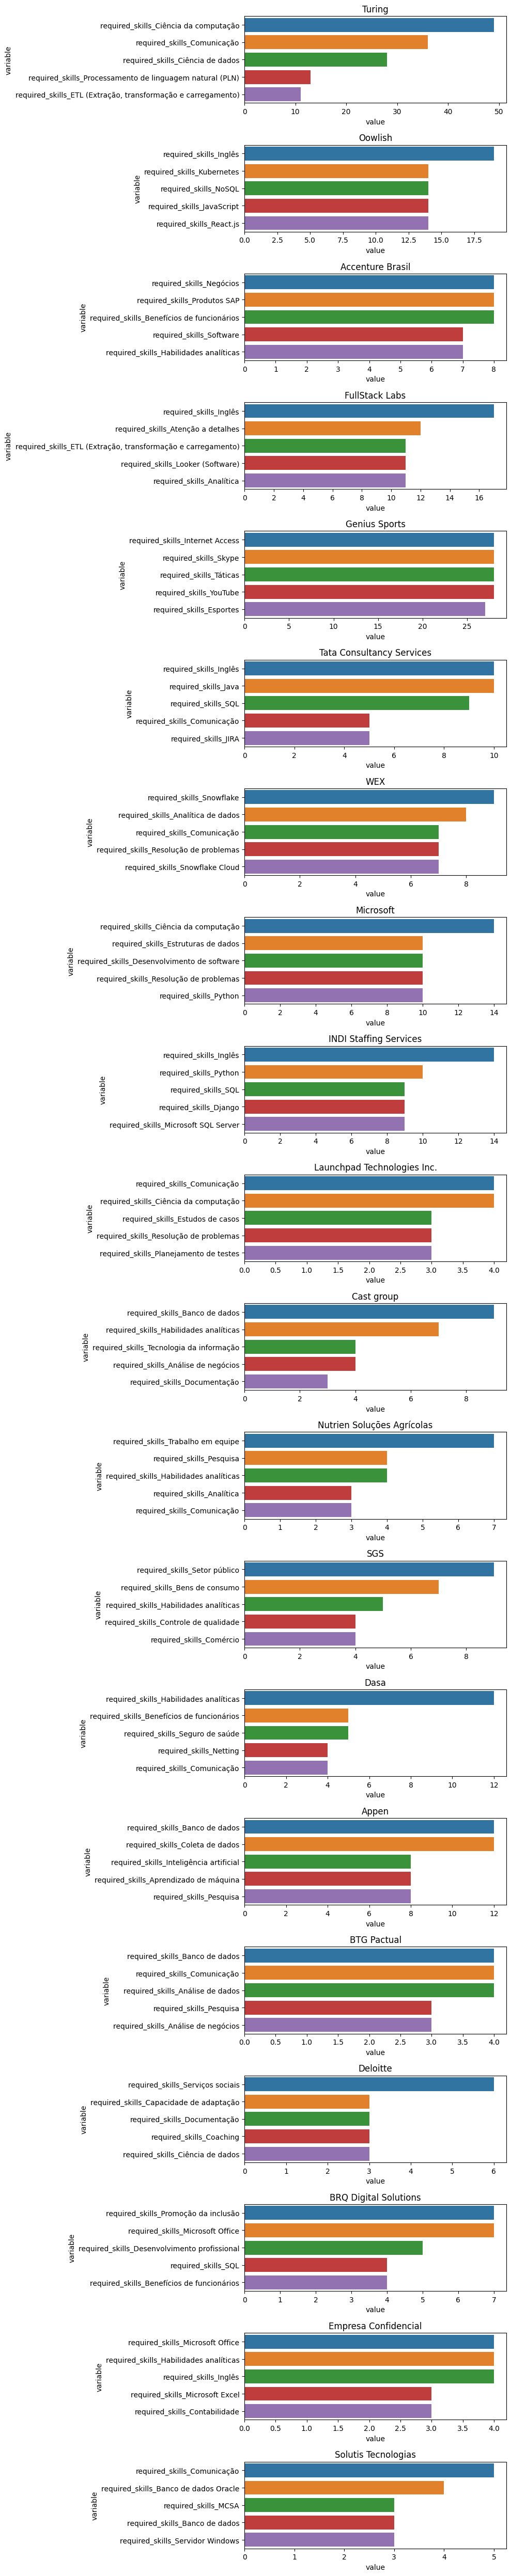

In [270]:
fig, ax = plt.subplots(len(list_dfs_top_companies), 1, figsize=(10, 50))
for i, company in enumerate(list_dfs_top_companies):
    sns.barplot(data=company, y='variable', x='value', ax=ax[i])
    ax[i].set_title(company.iloc[1, 1])
plt.tight_layout()

In [273]:
grouped_companies

index           company_name  required_skills_.NET Core  \
0      617                 Turing                          0   
1      438                Oowlish                          0   
2       22       Accenture Brasil                          0   
3      247         FullStack Labs                          0   
4      265          Genius Sports                          0   
..     ...                    ...                        ...   
682    274  GreenYellow do Brasil                          0   
683    268              GetNinjas                          0   
684    267                Gestamp                          0   
685    266              Genus PLC                          0   
686    686           ília digital                          0   

     required_skills_.NET Framework  required_skills_24 horas  \
0                                 0                         0   
1                                 0                         0   
2                                 0                         0   
3                                 2                         0   
4                                 0                         0   
..                              ...                       ...   
682                               0                         0   
683                               0                         0   
684                               0                         0   
685                               0                         0   
686                               0                         0   

     required_skills_3D Math  required_skills_3ds Max  required_skills_5G  \
0                          0                        0                   0   
1                          0                        0                   0   
2                          0                        0                   0   
3                          0                        0                   0   
4                          0                        0                   0   
..                       ...                      ...                 ...   
682                        0                        0                   0   
683                        0                        0                   0   
684                        0                        0                   0   
685                        0                        0                   0   
686                        0                        0                   0   

     required_skills_5G NR (New Radio)  required_skills_5S  ...  \
0                                    0                   0  ...   
1                                    0                   0  ...   
2                                    0                   0  ...   
3                                    0                   0  ...   
4                                    0                   0  ...   
..                                 ...                 ...  ...   
682                                  0                   0  ...   
683                                  0                   0  ...   
684                                  0                   0  ...   
685                                  0                   0  ...   
686                                  0                   0  ...   

     required_skills_comScore  required_skills_eSourcing  required_skills_iOS  \
0                           0                          0                    1   
1                           0                          0                    0   
2                           0                          0                    0   
3                           0                          0                    0   
4                           0                          0                    0   
..                        ...                        ...                  ...   
682                         0                          0                    0   
683                         0                          0                    0

In [279]:
df_sector_grouped = df_jobs_merged.groupby('company_sector')[col_required_skills].agg(agg_col_required_skills).reset_index().sort_values(by='position', ascending=False).reset_index()

In [283]:
df_sector_grouped['required_skills_.NET Core'].sum()

7

Serviços e consultoria de TI
Desenvolvimento de software
Serviços financeiros
Tecnologia, Informação e Internet
Recrutamento e seleção
Consultoria e serviços empresariais
Varejo
Bancos
Telecomunicações
Fabricação de alimentos e bebidas
Agricultura
Tecnologia da informação e serviços
Serviços de publicidade
Hospitais e atendimento à saúde
Transporte, Logística, Cadeia de Suprimentos e Armazenamento
Serviços de recursos humanos
Fabricação de produtos farmacêuticos
Serviços de informação
Fabricação de máquinas de automação
Indústrias de transformação
Serviços ambientais
Seguros
Fabricação de veículos
Petróleo e gás
Comércio e desenvolvimento internacional
Fabricação de maquinário
Consultoria de terceirização e offshoring
Fabricação de produtos químicos
Fabricação de aparelhos elétricos e eletrônicos
Publicação na Internet
Serviços de alimentos e bebidas
Pesquisa biotecnológica
Obras de infra-estrutura
Produtos alimentícios
Serviços profissionais
Varejo de vestuário e moda
Fabricação de se

In [298]:
for skill in counted_skills.required_skills.head(10):
    #counted_skills[f'perc_{skill}'] = df_sector_grouped[] / df_sector_grouped[skill].sum()
    for sector in list(df_sector_grouped.company_sector):
        mask_sector = df_sector_grouped['company_sector'] == sector
        skill_col = f'required_skills_{skill}'
        counted_skills[f'perc_{skill}'] = df_sector_grouped[mask_sector][skill_col].sum() / df_sector_grouped[skill_col].sum()

In [299]:
counted_skills

required_skills  count  percentage_count  \
1219                    Habilidades analíticas    394          0.027304   
479                                Comunicação    353          0.024463   
1320                                    Inglês    329          0.022800   
297                             Banco de dados    255          0.017672   
135                           Análise de dados    224          0.015523   
...                                        ...    ...               ...   
1203                           Grupos diversos      1          0.000069   
1202  Grupos de recursos de funcionários (GRF)      1          0.000069   
1200                       Group Communication      1          0.000069   
1194                                    Gradle      1          0.000069   
2666                        Ética profissional      1          0.000069   

                       category  perc_Habilidades analíticas  \
1219                       None                     0.002538   
479                 Comunicação                     0.002538   
1320                Comunicação                     0.002538   
297   Tecnologias e ferramentas                     0.002538   
135      Habilidades analíticas                     0.002538   
...                         ...                          ...   
1203                       None                     0.002538   
1202                       None                     0.002538   
1200                       None                     0.002538   
1194                       None                     0.002538   
2666                       None                     0.002538   

      perc_Comunicação  perc_Inglês  perc_Banco de dados  \
1219               0.0          0.0             0.003922   
479                0.0          0.0             0.003922   
1320               0.0          0.0             0.003922   
297                0.0          0.0             0.003922   
135                0.0          0.0             0.003922   
...                ...          ...                  ...   
1203               0.0          0.0             0.003922   
1202               0.0          0.0             0.003922   
1200               0.0          0.0             0.003922   
1194               0.0          0.0             0.003922   
2666               0.0          0.0             0.003922   

      perc_Análise de dados  perc_SQL  perc_Resolução de problemas  \
1219               0.004464       0.0                          0.0   
479                0.004464       0.0                          0.0   
1320               0.004464       0.0                          0.0   
297                0.004464       0.0                          0.0   
135                0.004464       0.0                          0.0   
...                     ...       ...                          ...   
1203               0.004464       0.0                          0.0   
1202               0.004464       0.0                          0.0   
1200               0.004464       0.0                          0.0   
1194               0.004464       0.0                          0.0   
2666               0.004464       0.0                          0.0   

      perc_Python  perc_Ciência da computação  perc_Ciência de dados  
1219          0.0                         0.0                    0.0  
479           0.0                         0.0                    0.0  
1320          0.0                         0.0                    0.0  
297           0.0                         0.0                    0.0  
135           0.0                         0.0                    0.0  
...           ...                         ...                    ...  
1203          0.0                         0.0                    0.0  
1202          0.0                         0.0                    0.0  
1200          0.0                         0.0                    0.0  
1194          0.0                         0.0                    0.0  
2666          0.0 

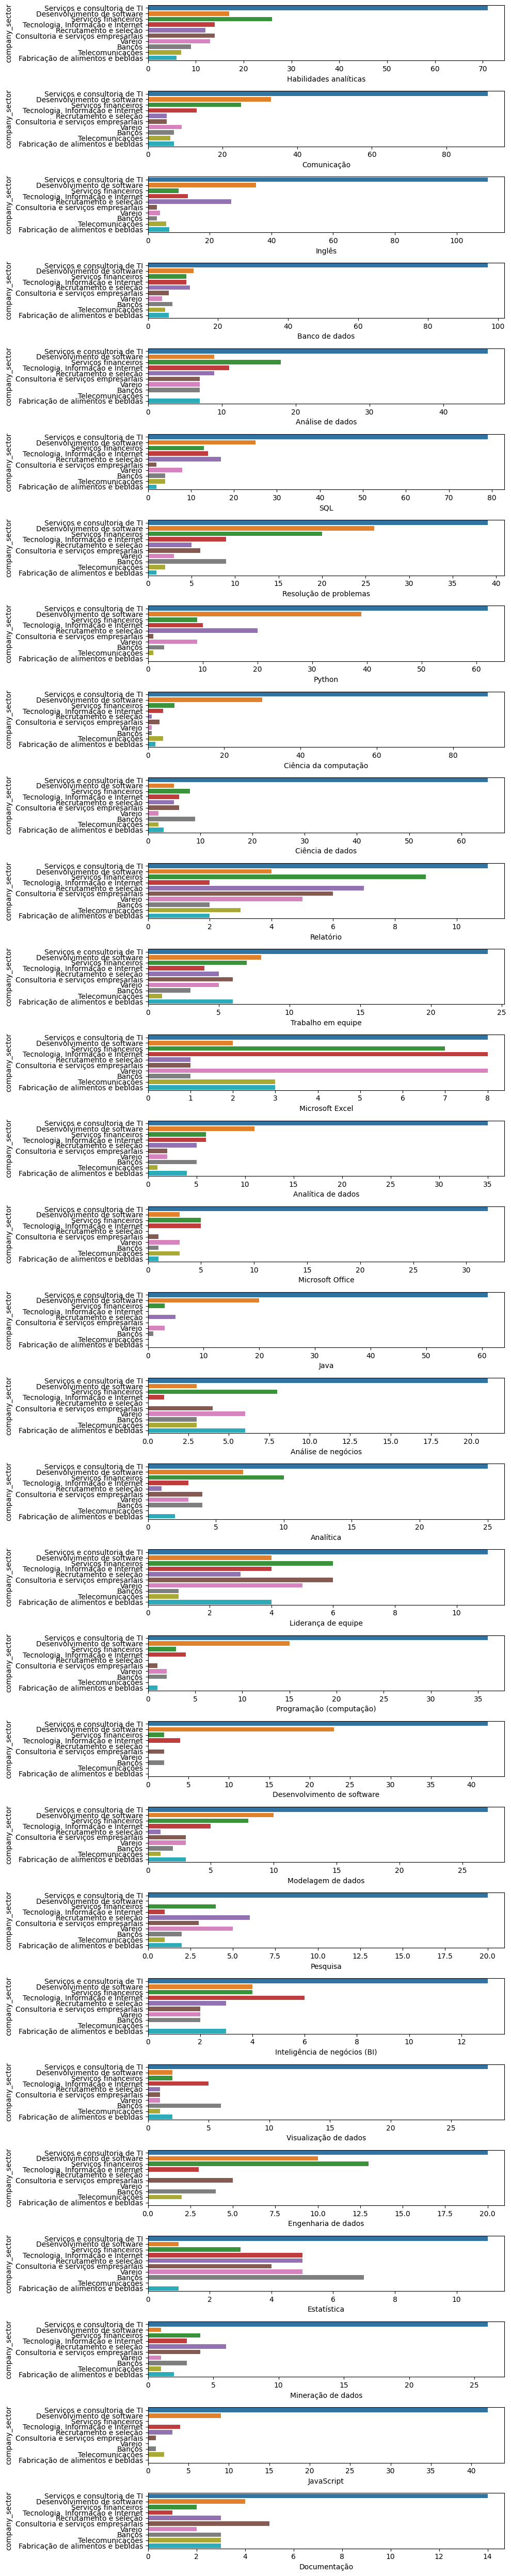

In [280]:
fig, ax = plt.subplots(30, 1, figsize=(10, 50))
for i, skill in enumerate(counted_skills.required_skills.head(30)):
    key = f'required_skills_{skill}'
    sns.barplot(data=df_sector_grouped.head(10), x=key, y='company_sector', ax=ax[i])
    ax[i].set_xlabel(skill)

plt.tight_layout()